## Machine Learning Nanodegree - Capstone Project
### Who is in the photo?
The proposal of this project is to build a model that allow to recognize persons in the image using Deep Learning. 
In this notebook, I will tests 3 architectures of CNN:

* VGG16 with transfer learning 
* ResNet50 with transfer learning
* A custom architecture


### First, Load and Clean up the dataset 

In [1]:
%matplotlib inline

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2


def load_face_dataset(path):
    data = load_files(path)
    general_targets = data['target']
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 83)
    return face_files, face_targets

train_files, train_targets = load_face_dataset('../faces/train')
valid_files, valid_targets = load_face_dataset('../faces/valid')
test_files, test_targets = load_face_dataset('../faces/test')

person_names = [item[15:-1] for item in sorted(glob("../faces/train/*/"))]

print(str(len(train_files)))
print('There are %d total person names.' % len(person_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))

Using TensorFlow backend.


11071
There are 83 total person names.
There are 13823 total face images.

There are 11071 training face images.
There are 1364 validation face images.
There are 1388 test face images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

haar_cascade_path = '../project/haarcascades/haarcascade_frontalface_default.xml'
detector= cv2.CascadeClassifier(haar_cascade_path);

def extract_face(img, target_size):
    img = img.astype(np.uint8)
    faces = detector.detectMultiScale(img)
    if len(faces)> 0:
        x,y,w,h =  faces[0]
        img = img[y:y+h,x:x+w]
        img = image.array_to_img(img)
        img = img.resize(target_size)
        img = image.img_to_array(img)
        return img
    return []


def path_to_tensor(img_path, target_size=(100,100), gray_scale=False):
    img = image.load_img(img_path, target_size=target_size, grayscale=gray_scale)
    img = image.img_to_array(img)
    face = extract_face(img, target_size)
    if len(face) == 0:
        return np.expand_dims(img, axis=0)    
    return np.expand_dims(face, axis=0)

def paths_to_tensor(img_paths, target_size=(100,100), gray_scale=False):
    #list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in tqdm(img_paths)]
    list_of_tensors = []
    for img_path in tqdm(img_paths):
        tensor = path_to_tensor(img_path, target_size, gray_scale)
        if len(tensor) > 0:
            list_of_tensors.append(tensor)
    return np.vstack(list_of_tensors)

#### Convert image to array

In [5]:
import cv2
from scipy.misc import imread
from scipy.misc import imresize
from tqdm import tqdm

def load_image_from(img_path):
    img = cv2.imread(img_path)
#    img = cv2.resize(img,(100,100))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def load_images_from(img_paths):
    images = [load_image_from(path) for path in tqdm(img_paths)]
    return np.array(images)

#### Load data to train, test and validate

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files, gray_scale=True).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, gray_scale=True).astype('float32')/255
test_tensors = paths_to_tensor(test_files, gray_scale=True).astype('float32')/255



100%|█████████████████████████████████████| 1388/1388 [00:12<00:00, 111.96it/s]


11071
11071
Julia Stiles
(100, 100, 1)
(100, 100)


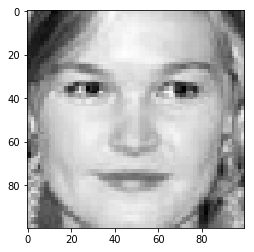

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
print(len(train_targets))
print(len(train_tensors))
index = np.where(train_targets[1] ==1)
print(person_names[45]) # gets an random example
img = train_tensors[1]
print(img.shape)
img = img.squeeze()
print(img.shape)
plt.imshow(img, cmap=cm.gray)
plt.show()

## Deep Learning Models

I will use Convolutional Networks for the Deep Learning Models. In this section, I will starting checking some CNN Architectures, starting with VGG16.

#### Create some utitlity functions to visualize the performance of the models

In [6]:
def visualize_loss(xc, train_loss, validation_loss):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_loss)
    plt.plot(xc, validation_loss)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Loss vs Validation Loss')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()


In [7]:
def visualize_acc(xc, train_acc, validation_acc):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_acc)
    plt.plot(xc, validation_acc)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()

In [8]:
from keras import backend as K

def get_featuresmaps(model, layer_index, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer_index].output,])
    activations = get_activations([X_batch, 0])
    return activations

In [9]:
def visualize_layer(model,image,layer_num=1, filter_num=1):
    activations = get_featuresmaps(model, int(layer_num), image)
    feature_maps = activations[0][0]
    fit = plt.figure(figsize=(5,5))
    plt.imshow(feature_maps[:,:, filter_num], cmap='gray')
    plt.savefig("featuremaps-layer-{}".format(layer_num)+"-filternum-{}".format(filter_num)+".jpg")
    
    num_of_featuremaps=feature_maps.shape[2]
    fig = plt.figure(figsize=(16,16))
    plt.title("featuremaps-layer-{}".format(layer_num))
    subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
    for i in range(int(num_of_featuremaps)):
        ax = fig.add_subplot(subplot_num, subplot_num, i+1)
        ax.imshow(feature_maps[:,:,i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()
    fig.savefig('featuremaps-layer-{}'.format(layer_num)+'.jpg')

In [10]:
def show_predictions(test_image, model):
    predictions = model.predict(test_image)
    index = np.where(predictions==1)

    index = index[1][0]
    return person_names[index]


In [11]:
def compare_prediction(test_image, prediction_class):
    img = test_image
    plt.imshow(img)
    plt.show()
    
    validation_image = None
    for test_file in test_files:
        if prediction_class in test_file:
            validation_image = test_file
            break
    
    print("Validation image: "+validation_image)
    if validation_image:
        validation_image = cv2.imread(validation_image) 
        plt.imshow(validation_image)
        plt.show()

### VGG16s

The origin of VGG architecture was a paper written by Simonyan and Zisserman in 2014 called: Very Deep Convolutional Networks for Large Scale Image Recognition [http://www.image-net.org/challenges/LSVRC/]

This network is characterized by its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. Reducing volume size is handled by max pooling. Two fully-connected layers, each with 4,096 nodes are then followed by a softmax classifier 

In [11]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Dropout, Flatten, Dense
from keras.callbacks import TensorBoard


In [15]:
vgg16_model = VGG16(input_tensor=Input(shape=(100,100,3)),include_top=False,weights='imagenet')
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [16]:
last_layer = vgg16_model.get_layer('block5_pool').output
custom_layer = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Dropout(0.5)(custom_layer)
custom_layer = Flatten()(custom_layer)
custom_layer = Dense(100, activation='relu')(custom_layer)
output = Dense(83, activation='softmax')(custom_layer)

custom_vgg16_model = Model(vgg16_model.input, output)
custom_vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [17]:
from keras.optimizers import SGD

custom_vgg16_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.005), metrics=['accuracy'])

In [64]:
from keras.callbacks import ModelCheckpoint  
from time import time
epochs =70

checkpointer = ModelCheckpoint(filepath='saved_models/custom_vgg16_weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

# to debug on tensorboard uncomment this line and put tensoboard on model callback
# tensorboard = TensorBoard(log_dir="logs/vgg16_{}".format(time()),write_images=True,write_grads=True)

trainning_result = custom_vgg16_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 11071 samples, validate on 1364 samples
Epoch 1/70
11071/11071 [==============================] - 134s 12ms/step - loss: 4.3918 - acc: 0.0222 - val_loss: 4.3004 - val_acc: 0.0572
Epoch 2/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 4.2192 - acc: 0.0000e+0 - ETA: 1:58 - loss: 4.0873 - acc: 0.1000    - ETA: 1:59 - loss: 4.1661 - acc: 0.066 - ETA: 1:59 - loss: 4.1914 - acc: 0.050 - ETA: 1:59 - loss: 4.1588 - acc: 0.080 - ETA: 1:59 - loss: 4.2466 - acc: 0.066 - ETA: 1:59 - loss: 4.2496 - acc: 0.057 - ETA: 1:59 - loss: 4.2603 - acc: 0.050 - ETA: 1:59 - loss: 4.2409 - acc: 0.055 - ETA: 1:59 - loss: 4.2652 - acc: 0.050 - ETA: 1:59 - loss: 4.2645 - acc: 0.045 - ETA: 1:59 - loss: 4.2653 - acc: 0.041 - ETA: 1:59 - loss: 4.2484 - acc: 0.046 - ETA: 1:59 - loss: 4.2559 - acc: 0.050 - ETA: 1:59 - loss: 4.2486 - acc: 0.060 - ETA: 1:59 - loss: 4.2410 - acc: 0.062 - ETA: 1:59 - loss: 4.2130 - acc: 0.064 - ETA: 1:59 - loss: 4.2247 - acc: 0.061 - ETA: 1:59 - loss: 4.2188 - acc: 0.057 - ETA: 1:59 - loss: 4.2157 - acc: 0.055 - ETA: 1:59 - loss: 4.2312 - acc: 0.052 - ETA: 1:59 - loss: 4.2346 - acc: 0.054 - ETA: 1:59 - loss: 4.2219 - acc: 0.056 - ETA: 1:59 - loss: 4.2168 

11071/11071 [==============================] - 127s 11ms/step - loss: 4.0574 - acc: 0.0665 - val_loss: 3.9030 - val_acc: 0.0726
Epoch 3/70
11071/11071 [==============================] - 128s 12ms/step - loss: 3.4240 - acc: 0.1534 - val_loss: 5.7816 - val_acc: 0.0440
Epoch 4/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 6.5890 - acc: 0.0000e+0 - ETA: 2:02 - loss: 5.3698 - acc: 0.0500    - ETA: 2:04 - loss: 4.7287 - acc: 0.066 - ETA: 2:06 - loss: 4.5084 - acc: 0.050 - ETA: 2:07 - loss: 4.3022 - acc: 0.060 - ETA: 2:06 - loss: 4.1942 - acc: 0.066 - ETA: 2:08 - loss: 4.0907 - acc: 0.071 - ETA: 2:10 - loss: 3.9292 - acc: 0.125 - ETA: 2:09 - loss: 3.8840 - acc: 0.122 - ETA: 2:08 - loss: 3.8336 - acc: 0.120 - ETA: 2:07 - loss: 3.7996 - acc: 0.109 - ETA: 2:07 - loss: 3.7029 - acc: 0.125 - ETA: 2:06 - loss: 3.6111 - acc: 0.146 - ETA: 2:06 - loss: 3.5576 - acc: 0.157 - ETA: 2:05 - loss: 3.5573 - acc: 0.153 - ETA: 2:05 - loss: 3.5366 - acc: 0.156 - ETA: 2:04 - loss: 3.4907 - acc: 0.158 - ETA: 2:04 - loss: 3.4906 - acc: 0.161 - ETA: 2:03 - loss: 3.4819 - acc: 0.157 - ETA: 2:03 - loss: 3.4652 - acc: 0.165 - ETA: 2:03 - loss: 3.4489 - acc: 0.166 - ETA: 2:03 - loss: 3.4257 - acc: 0.172 - ETA: 2:02 - loss: 3.3675 - acc: 0.182 - ETA: 2:02 - loss: 3.3485 

11071/11071 [==============================] - 127s 11ms/step - loss: 2.7787 - acc: 0.2803 - val_loss: 6.9596 - val_acc: 0.0623
Epoch 5/70
11071/11071 [==============================] - 130s 12ms/step - loss: 2.2386 - acc: 0.3984 - val_loss: 3.1955 - val_acc: 0.3475
Epoch 6/70


 2040/11071 [====>.........................] - ETA: 2:01 - loss: 3.9483 - acc: 0.300 - ETA: 2:01 - loss: 2.9359 - acc: 0.400 - ETA: 2:00 - loss: 2.4943 - acc: 0.466 - ETA: 2:01 - loss: 2.2108 - acc: 0.525 - ETA: 2:00 - loss: 2.1232 - acc: 0.520 - ETA: 1:59 - loss: 2.1476 - acc: 0.483 - ETA: 1:59 - loss: 2.0416 - acc: 0.500 - ETA: 1:59 - loss: 2.0104 - acc: 0.512 - ETA: 1:59 - loss: 1.9697 - acc: 0.511 - ETA: 1:59 - loss: 1.9702 - acc: 0.500 - ETA: 1:59 - loss: 1.9814 - acc: 0.500 - ETA: 1:59 - loss: 1.9204 - acc: 0.525 - ETA: 1:59 - loss: 1.9019 - acc: 0.530 - ETA: 1:59 - loss: 1.9516 - acc: 0.514 - ETA: 1:59 - loss: 1.9059 - acc: 0.526 - ETA: 1:58 - loss: 1.9039 - acc: 0.518 - ETA: 1:58 - loss: 1.9424 - acc: 0.511 - ETA: 1:58 - loss: 1.9638 - acc: 0.500 - ETA: 1:58 - loss: 1.9523 - acc: 0.510 - ETA: 1:58 - loss: 1.9366 - acc: 0.515 - ETA: 1:58 - loss: 1.9281 - acc: 0.514 - ETA: 1:58 - loss: 1.9189 - acc: 0.509 - ETA: 1:58 - loss: 1.9100 - acc: 0.504 - ETA: 1:58 - loss: 1.8754 - acc: 0

11071/11071 [==============================] - 126s 11ms/step - loss: 1.6897 - acc: 0.5334 - val_loss: 3.1994 - val_acc: 0.3438
Epoch 7/70
11071/11071 [==============================] - 129s 12ms/step - loss: 1.2804 - acc: 0.6443 - val_loss: 3.7868 - val_acc: 0.2434
Epoch 8/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 4.7600 - acc: 0.200 - ETA: 1:59 - loss: 3.9083 - acc: 0.250 - ETA: 1:59 - loss: 2.9650 - acc: 0.433 - ETA: 1:59 - loss: 2.4408 - acc: 0.525 - ETA: 2:00 - loss: 2.1649 - acc: 0.540 - ETA: 2:00 - loss: 2.0363 - acc: 0.516 - ETA: 2:00 - loss: 1.8390 - acc: 0.571 - ETA: 2:00 - loss: 1.8192 - acc: 0.550 - ETA: 2:00 - loss: 1.7827 - acc: 0.555 - ETA: 2:00 - loss: 1.6908 - acc: 0.580 - ETA: 2:00 - loss: 1.6281 - acc: 0.590 - ETA: 2:01 - loss: 1.5861 - acc: 0.591 - ETA: 2:01 - loss: 1.5554 - acc: 0.600 - ETA: 2:01 - loss: 1.5447 - acc: 0.607 - ETA: 2:02 - loss: 1.4889 - acc: 0.613 - ETA: 2:02 - loss: 1.4916 - acc: 0.606 - ETA: 2:02 - loss: 1.5014 - acc: 0.617 - ETA: 2:02 - loss: 1.4674 - acc: 0.616 - ETA: 2:02 - loss: 1.4623 - acc: 0.610 - ETA: 2:02 - loss: 1.4655 - acc: 0.610 - ETA: 2:01 - loss: 1.4112 - acc: 0.628 - ETA: 2:01 - loss: 1.3843 - acc: 0.631 - ETA: 2:01 - loss: 1.3540 - acc: 0.643 - ETA: 2:01 - loss: 1.3279 - acc: 0

11071/11071 [==============================] - 129s 12ms/step - loss: 0.9706 - acc: 0.7291 - val_loss: 1.4230 - val_acc: 0.6158
Epoch 9/70
11071/11071 [==============================] - 127s 12ms/step - loss: 0.7122 - acc: 0.7990 - val_loss: 4.6349 - val_acc: 0.1268
Epoch 10/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 3.8099 - acc: 0.200 - ETA: 1:58 - loss: 3.8552 - acc: 0.150 - ETA: 1:59 - loss: 3.0509 - acc: 0.266 - ETA: 1:59 - loss: 2.8639 - acc: 0.300 - ETA: 2:00 - loss: 2.4981 - acc: 0.400 - ETA: 2:00 - loss: 2.2896 - acc: 0.433 - ETA: 2:00 - loss: 2.0421 - acc: 0.500 - ETA: 2:00 - loss: 1.8495 - acc: 0.537 - ETA: 2:00 - loss: 1.8042 - acc: 0.544 - ETA: 2:00 - loss: 1.6945 - acc: 0.580 - ETA: 2:00 - loss: 1.6385 - acc: 0.600 - ETA: 2:00 - loss: 1.5633 - acc: 0.616 - ETA: 2:00 - loss: 1.4543 - acc: 0.646 - ETA: 2:00 - loss: 1.4136 - acc: 0.642 - ETA: 2:00 - loss: 1.3304 - acc: 0.666 - ETA: 2:00 - loss: 1.3135 - acc: 0.668 - ETA: 2:00 - loss: 1.2749 - acc: 0.670 - ETA: 2:00 - loss: 1.2452 - acc: 0.672 - ETA: 1:59 - loss: 1.2165 - acc: 0.678 - ETA: 1:59 - loss: 1.2119 - acc: 0.675 - ETA: 1:59 - loss: 1.1941 - acc: 0.681 - ETA: 1:59 - loss: 1.1724 - acc: 0.686 - ETA: 1:59 - loss: 1.1398 - acc: 0.691 - ETA: 1:59 - loss: 1.1428 - acc: 0

11071/11071 [==============================] - 127s 11ms/step - loss: 0.5816 - acc: 0.8343 - val_loss: 15.7592 - val_acc: 0.0220
Epoch 11/70
11071/11071 [==============================] - 127s 11ms/step - loss: 0.5362 - acc: 0.8581 - val_loss: 0.6848 - val_acc: 0.8189
Epoch 12/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 0.1663 - acc: 1.000 - ETA: 1:59 - loss: 0.3884 - acc: 0.800 - ETA: 1:59 - loss: 0.3374 - acc: 0.833 - ETA: 2:00 - loss: 0.3704 - acc: 0.825 - ETA: 2:01 - loss: 0.3398 - acc: 0.860 - ETA: 2:00 - loss: 0.2854 - acc: 0.883 - ETA: 2:00 - loss: 0.2533 - acc: 0.900 - ETA: 2:00 - loss: 0.2334 - acc: 0.900 - ETA: 2:00 - loss: 0.2118 - acc: 0.911 - ETA: 2:01 - loss: 0.2042 - acc: 0.910 - ETA: 2:01 - loss: 0.2025 - acc: 0.909 - ETA: 2:01 - loss: 0.2037 - acc: 0.908 - ETA: 2:00 - loss: 0.1915 - acc: 0.915 - ETA: 2:00 - loss: 0.1807 - acc: 0.921 - ETA: 2:00 - loss: 0.1705 - acc: 0.926 - ETA: 2:00 - loss: 0.1615 - acc: 0.931 - ETA: 2:00 - loss: 0.1524 - acc: 0.935 - ETA: 2:00 - loss: 0.1451 - acc: 0.938 - ETA: 2:00 - loss: 0.1655 - acc: 0.936 - ETA: 2:00 - loss: 0.1698 - acc: 0.935 - ETA: 2:00 - loss: 0.1945 - acc: 0.928 - ETA: 2:00 - loss: 0.1877 - acc: 0.931 - ETA: 2:00 - loss: 0.2050 - acc: 0.926 - ETA: 1:59 - loss: 0.2017 - acc: 0

11071/11071 [==============================] - 127s 11ms/step - loss: 0.3241 - acc: 0.9078 - val_loss: 0.7613 - val_acc: 0.8109
Epoch 13/70
11071/11071 [==============================] - 127s 12ms/step - loss: 0.2340 - acc: 0.9336 - val_loss: 0.8465 - val_acc: 0.8138
Epoch 14/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 0.0069 - acc: 1.000 - ETA: 2:00 - loss: 0.0037 - acc: 1.000 - ETA: 2:00 - loss: 0.1674 - acc: 0.966 - ETA: 2:00 - loss: 0.1261 - acc: 0.975 - ETA: 2:00 - loss: 0.1224 - acc: 0.980 - ETA: 2:00 - loss: 0.1050 - acc: 0.983 - ETA: 2:00 - loss: 0.1439 - acc: 0.971 - ETA: 2:00 - loss: 0.1284 - acc: 0.975 - ETA: 2:00 - loss: 0.1156 - acc: 0.977 - ETA: 2:00 - loss: 0.1047 - acc: 0.980 - ETA: 2:00 - loss: 0.1043 - acc: 0.981 - ETA: 2:00 - loss: 0.0964 - acc: 0.983 - ETA: 2:00 - loss: 0.0891 - acc: 0.984 - ETA: 2:00 - loss: 0.0830 - acc: 0.985 - ETA: 2:00 - loss: 0.0819 - acc: 0.986 - ETA: 2:00 - loss: 0.0913 - acc: 0.987 - ETA: 1:59 - loss: 0.0868 - acc: 0.988 - ETA: 1:59 - loss: 0.0857 - acc: 0.988 - ETA: 1:59 - loss: 0.0883 - acc: 0.989 - ETA: 1:59 - loss: 0.0851 - acc: 0.990 - ETA: 1:59 - loss: 0.0819 - acc: 0.990 - ETA: 1:59 - loss: 0.0784 - acc: 0.990 - ETA: 1:59 - loss: 0.0815 - acc: 0.987 - ETA: 1:59 - loss: 0.0856 - acc: 0

11071/11071 [==============================] - 130s 12ms/step - loss: 0.1845 - acc: 0.9455 - val_loss: 0.8080 - val_acc: 0.8145
Epoch 15/70
  470/11071 [>.............................] - ETA: 2:07 - loss: 0.1238 - acc: 1.000 - ETA: 2:04 - loss: 0.2152 - acc: 0.950 - ETA: 2:04 - loss: 0.2116 - acc: 0.933 - ETA: 2:04 - loss: 0.1787 - acc: 0.950 - ETA: 2:04 - loss: 0.1914 - acc: 0.940 - ETA: 2:04 - loss: 0.1862 - acc: 0.950 - ETA: 2:03 - loss: 0.1671 - acc: 0.957 - ETA: 2:03 - loss: 0.1536 - acc: 0.962 - ETA: 2:03 - loss: 0.1403 - acc: 0.966 - ETA: 2:03 - loss: 0.1271 - acc: 0.970 - ETA: 2:04 - loss: 0.1168 - acc: 0.972 - ETA: 2:04 - loss: 0.1094 - acc: 0.975 - ETA: 2:04 - loss: 0.1030 - acc: 0.976 - ETA: 2:04 - loss: 0.1007 - acc: 0.978 - ETA: 2:04 - loss: 0.1036 - acc: 0.980 - ETA: 2:04 - loss: 0.0994 - acc: 0.981 - ETA: 2:04 - loss: 0.0995 - acc: 0.976 - ETA: 2:03 - loss: 0.0971 - acc: 0.977 - ETA: 2:03 - loss: 0.0949 - acc: 0.978 - ETA: 2:03 - loss: 0.0945 - acc: 0.980 - ETA: 2:03 - l

KeyboardInterrupt: 

#### Load VGG16 weights trained on a GPU machine

In [17]:
custom_vgg16_model.load_weights('saved_models/custom_vgg16_weights.custom.model.hdf5')

In [18]:
scores = custom_vgg16_model.evaluate(test_tensors, test_targets, batch_size=10)

1388/1388 [==============================] - ETA: 11:4 - ETA: 3:5 - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 53s - ETA: 45 - ETA: 40 - ETA: 35 - ETA: 32 - ETA: 29 - ETA: 26 - ETA: 24 - ETA: 22 - ETA: 21 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 7ms/step


In [19]:
print(scores)

[2.2424631088285008, 0.57420750868423531]


### Testing the model

In [19]:
test_image_tensor = path_to_tensor('../obama.jpeg')
test_image = cv2.imread('../obama.jpeg')
print (test_image_tensor.shape)

(1, 100, 100, 3)


Steve Carell


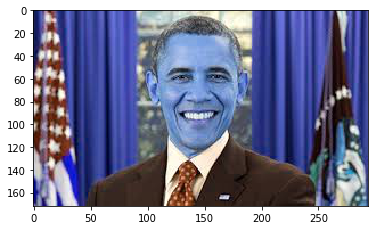

../faces/test\Steve Carell\38.jpg


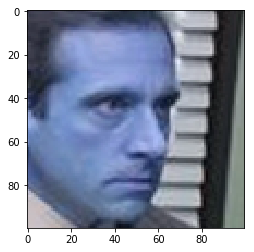

In [20]:
prediction_class = show_predictions(test_image_tensor, custom_vgg16_model)
print(prediction_class)

compare_prediction(test_image, prediction_class)


#### Visualizing the layers

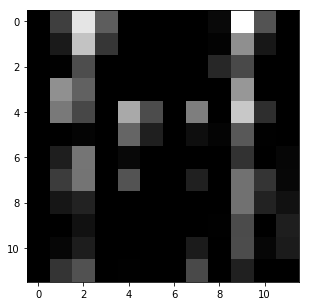

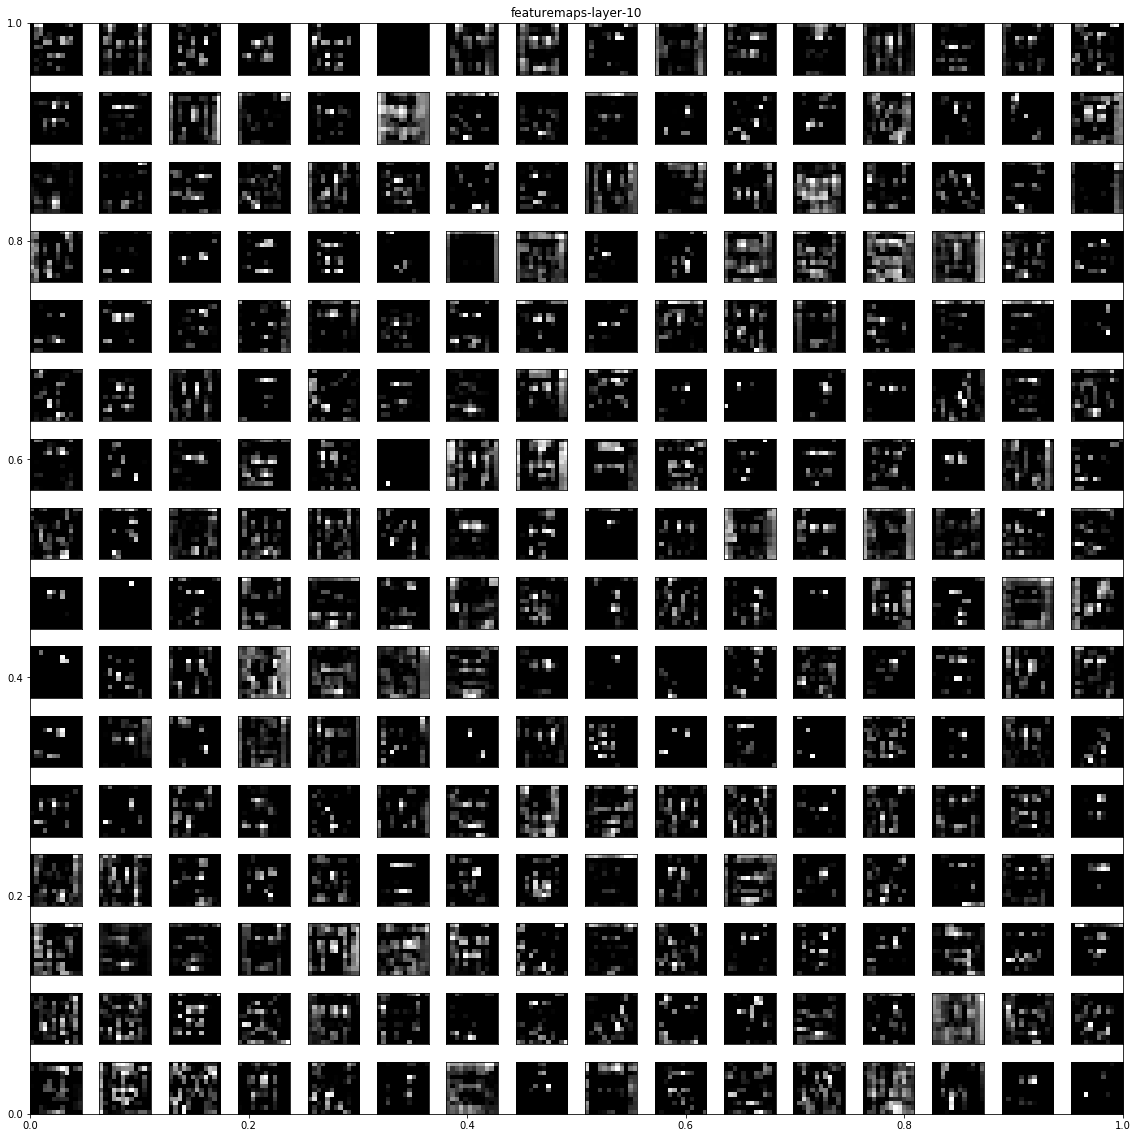

In [21]:
visualize_layer(custom_vgg16_model, test_image_tensor, layer_num=10)

### ResNet50

ResNet is a short name for Residual Network. As the name of the network indicates, the new terminology that this network introduces is residual learning.

What is Residual Learning?

In general, in a deep convolutional neural network, several layers are stacked and are trained to the task at hand. The network learns several low/mid/high level features at the end of its layers. In residual learning, instead of trying to learn some features, we try to learn some residual. Residual can be simply understood as subtraction of feature learned from input of that layer. ResNet does this using shortcut connections (directly connecting input of nth layer to some (n+x)th layer. It has proved that training this form of networks is easier than training simple deep convolutional neural networks and also the problem of degrading accuracy is resolved.

This is the fundamental concept of ResNet.

ResNet50 is a 50 layer Residual Network. There are other variants like ResNet101 and ResNet152 also.

Definition extracted from this Quora anwer: https://www.quora.com/What-is-the-deep-neural-network-known-as-%E2%80%9CResNet-50%E2%80%9D

The paper original can be found here: https://arxiv.org/abs/1512.03385


#### Resize images to 224 x 224

In [19]:
from keras.applications.resnet50 import ResNet50

In [ ]:
# pre-process the data for Keras
train_tensors_224 = paths_to_tensor(train_files,target_size=(224,224)).astype('float32')/255
valid_tensors_224 = paths_to_tensor(valid_files,target_size=(224,224)).astype('float32')/255
test_tensors_224 = paths_to_tensor(test_files,target_size=(224,224)).astype('float32')/255

train_tensors_224 = train_tensors_224.reshape(train_tensors_224.shape[0], 224, 224, 3)
valid_tensors_224 = valid_tensors_224.reshape(valid_tensors_224.shape[0], 224, 224, 3)
test_tensors_224 = test_tensors_224.reshape(test_tensors_224.shape[0], 224, 224, 3)

 98%|███████████████████████████████████ | 10798/11071 [04:57<00:07, 36.34it/s]

In [20]:
resnet_model = ResNet50(input_tensor=Input(shape=(224,224,3)), include_top=False, weights='imagenet')
resnet_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 14, 14, 256)  0           bn4a_branch2a[0][0]              
__________________________________________________________________________________________________
res4a_bran

__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_45[0][0]              
__________________________________________________________________________________________________
bn5b_branch2c (BatchNormalizati (None, 7, 7, 2048)   8192        res5b_branch2c[0][0]             
__________

In [21]:
from keras.layers import GlobalAveragePooling2D

last_layer = resnet_model.get_layer('avg_pool').output

custom_layer = Conv2D(filters=32, kernel_size=4, padding='same', activation='relu')(last_layer)
# custom_layer = Conv2D(filters=64, kernel_size=4, padding='same', activation='relu')(custom_layer)
# custom_layer = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(custom_layer)

custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=64, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=128, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=256, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

# custom_layer = Conv2D(filters=512, kernel_size=4, padding='same', activation='relu')(last_layer)
# custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Dropout(0.5)(custom_layer)

custom_layer = Flatten()(custom_layer)
custom_layer = Dense(224, activation='relu')(custom_layer)
out = Dense(83, activation='softmax')(custom_layer)

custom_restnet_model = Model(resnet_model.input, out)
custom_restnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 14, 14, 256)  0           bn4a_branch2a[0][0]              
__________________________________________________________________________________________________
res4a_bran

__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_45[0][0]              
__________________________________________________________________________________________________
bn5b_branch2c (BatchNormalizati (None, 7, 7, 2048)   8192        res5b_branch2c[0][0]             
__________

In [22]:
custom_restnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 70

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/custom_resnet50_weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

tensor = TensorBoard(log_dir="logs/resnet_{}".format(time()),write_images=True,write_grads=True)

trainning_result = custom_restnet_model.fit(train_tensors_224, train_targets, 
          validation_data=(valid_tensors_224, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer,tensor], verbose=1)

#### Load ResNet50 weights trained on a GPU machine

In [23]:
custom_restnet_model.load_weights('saved_models/custom_resnet50_weights.custom.model.hdf5')


In [124]:
scores = custom_restnet_model.evaluate(test_tensors_224, test_targets, batch_size=10)

print(scores)

1388/1388 [==============================] - 571s   
[2.3394022601997473, 0.42291066972726704]


#### Testing the model

In [141]:
test_image_tensor = path_to_tensor('../obama.jpeg', target_size=(224,224))
test_image = cv2.imread('../obama.jpeg')
print (test_image_tensor.shape)

(1, 224, 224, 3)


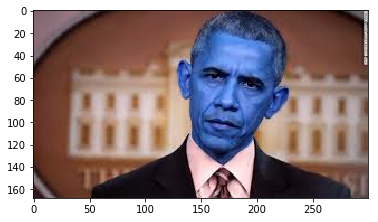

../faces/test/Daniel Radcliffe/666.jpg


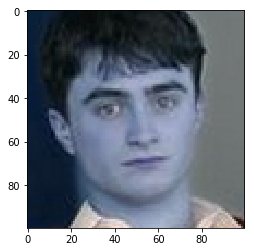

In [142]:
prediction_class = show_predictions(test_image_tensor, custom_restnet_model)
compare_prediction(test_image, prediction_class)

#### Visualizing the layers

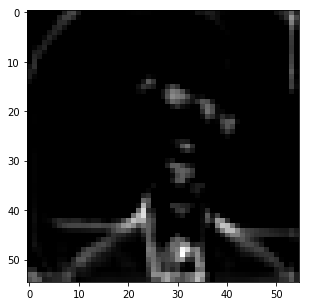

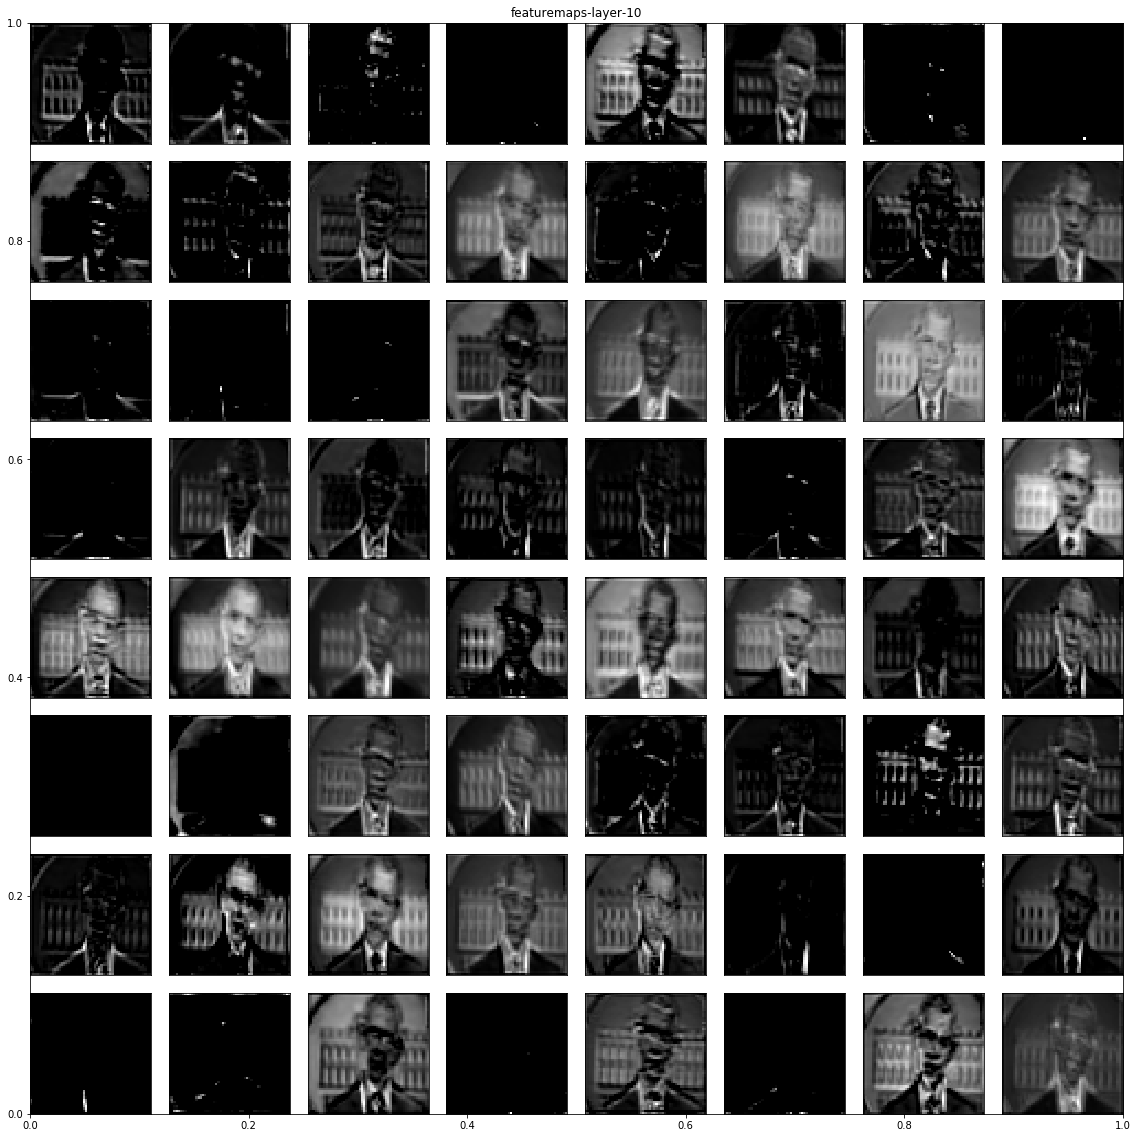

In [145]:
visualize_layer(custom_restnet_model, test_image_tensor, layer_num=10)

### Custom CNN Model

In this custom model, I use a sequence of 3 layers of convolutional and pooling. To reducing overfitting, I'm using a dropout. After that a fully connected layer and dropout again.
With this configuration, I get the better results.

In [28]:
import time
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam
from keras.callbacks import TensorBoard

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(100,100,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(83, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 256)       295168    
__________

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [30]:
from keras.callbacks import ModelCheckpoint  
from time import time
### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 90
### Do NOT modify the code below this line.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.custom.model_{}.hdf5'.format("pc20-batch20-ada"), 
                               verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="logs/custom_{}".format(time()))
#tensorboard = TensorBoard(log_dir="logs/vgg16_{}".format(time()),write_images=True,write_grads=True, histogram_freq=5.0)

trainning_result = model.fit(train_tensors, train_targets, 
           validation_data=(valid_tensors, valid_targets),
           epochs=epochs, batch_size=20, callbacks=[checkpointer,tensorboard], verbose=1)

Train on 11071 samples, validate on 1364 samples
Epoch 1/90


 8500/11071 [======================>.......] - ETA: 46s - loss: 4.4253 - acc: 0.0000e+ - ETA: 26s - loss: 4.4315 - acc: 0.0000e+ - ETA: 22s - loss: 4.4312 - acc: 0.0000e+ - ETA: 19s - loss: 4.4300 - acc: 0.0071   - ETA: 18s - loss: 4.4249 - acc: 0.01 - ETA: 18s - loss: 4.4254 - acc: 0.00 - ETA: 17s - loss: 4.4244 - acc: 0.00 - ETA: 17s - loss: 4.4244 - acc: 0.00 - ETA: 17s - loss: 4.4221 - acc: 0.01 - ETA: 16s - loss: 4.4243 - acc: 0.01 - ETA: 16s - loss: 4.4220 - acc: 0.01 - ETA: 16s - loss: 4.4211 - acc: 0.01 - ETA: 16s - loss: 4.4204 - acc: 0.01 - ETA: 16s - loss: 4.4218 - acc: 0.01 - ETA: 15s - loss: 4.4223 - acc: 0.01 - ETA: 15s - loss: 4.4212 - acc: 0.01 - ETA: 15s - loss: 4.4213 - acc: 0.01 - ETA: 15s - loss: 4.4202 - acc: 0.01 - ETA: 15s - loss: 4.4201 - acc: 0.01 - ETA: 15s - loss: 4.4198 - acc: 0.01 - ETA: 15s - loss: 4.4205 - acc: 0.01 - ETA: 15s - loss: 4.4204 - acc: 0.01 - ETA: 14s - loss: 4.4194 - acc: 0.01 - ETA: 14s - loss: 4.4194 - acc: 0.01 - ETA: 14s - loss: 4.4199 -

11071/11071 [==============================] - 17s 1ms/step - loss: 4.3986 - acc: 0.0190 - val_loss: 4.3768 - val_acc: 0.0271
Epoch 2/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 4.3163 - acc: 0.05 - ETA: 16s - loss: 4.3435 - acc: 0.03 - ETA: 16s - loss: 4.3532 - acc: 0.03 - ETA: 16s - loss: 4.3765 - acc: 0.02 - ETA: 16s - loss: 4.3782 - acc: 0.02 - ETA: 16s - loss: 4.3710 - acc: 0.02 - ETA: 16s - loss: 4.3621 - acc: 0.03 - ETA: 16s - loss: 4.3586 - acc: 0.03 - ETA: 15s - loss: 4.3534 - acc: 0.02 - ETA: 15s - loss: 4.3470 - acc: 0.02 - ETA: 15s - loss: 4.3490 - acc: 0.03 - ETA: 15s - loss: 4.3514 - acc: 0.03 - ETA: 15s - loss: 4.3550 - acc: 0.03 - ETA: 15s - loss: 4.3627 - acc: 0.03 - ETA: 15s - loss: 4.3647 - acc: 0.02 - ETA: 15s - loss: 4.3637 - acc: 0.03 - ETA: 16s - loss: 4.3643 - acc: 0.02 - ETA: 15s - loss: 4.3675 - acc: 0.03 - ETA: 15s - loss: 4.3696 - acc: 0.03 - ETA: 15s - loss: 4.3704 - acc: 0.03 - ETA: 15s - loss: 4.3670 - acc: 0.03 - ETA: 15s - loss: 4.3658 - acc: 0.03 - ETA: 15s - loss: 4.3693 - acc: 0.02 - ETA: 15s - loss: 4.3663 - acc: 0.03 - ETA: 15s - loss: 4.3675 - acc: 0.03 - ETA

11071/11071 [==============================] - 17s 2ms/step - loss: 4.3558 - acc: 0.0281 - val_loss: 4.2678 - val_acc: 0.0462
Epoch 3/90


 8540/11071 [======================>.......] - ETA: 14s - loss: 4.2707 - acc: 0.05 - ETA: 15s - loss: 4.2498 - acc: 0.03 - ETA: 16s - loss: 4.3036 - acc: 0.02 - ETA: 16s - loss: 4.3152 - acc: 0.02 - ETA: 15s - loss: 4.2934 - acc: 0.03 - ETA: 15s - loss: 4.3104 - acc: 0.03 - ETA: 15s - loss: 4.3000 - acc: 0.03 - ETA: 15s - loss: 4.2978 - acc: 0.03 - ETA: 15s - loss: 4.3050 - acc: 0.03 - ETA: 15s - loss: 4.2964 - acc: 0.03 - ETA: 15s - loss: 4.3027 - acc: 0.03 - ETA: 15s - loss: 4.2986 - acc: 0.03 - ETA: 15s - loss: 4.2902 - acc: 0.03 - ETA: 15s - loss: 4.2859 - acc: 0.03 - ETA: 15s - loss: 4.2848 - acc: 0.03 - ETA: 15s - loss: 4.2849 - acc: 0.03 - ETA: 15s - loss: 4.2935 - acc: 0.03 - ETA: 15s - loss: 4.2882 - acc: 0.03 - ETA: 16s - loss: 4.2869 - acc: 0.03 - ETA: 16s - loss: 4.2913 - acc: 0.02 - ETA: 16s - loss: 4.2846 - acc: 0.02 - ETA: 16s - loss: 4.2808 - acc: 0.02 - ETA: 15s - loss: 4.2772 - acc: 0.03 - ETA: 15s - loss: 4.2689 - acc: 0.03 - ETA: 15s - loss: 4.2615 - acc: 0.03 - ETA

11071/11071 [==============================] - 17s 2ms/step - loss: 4.2041 - acc: 0.0496 - val_loss: 3.9333 - val_acc: 0.0872
Epoch 4/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 3.9266 - acc: 0.10 - ETA: 16s - loss: 4.1672 - acc: 0.10 - ETA: 15s - loss: 4.1082 - acc: 0.07 - ETA: 15s - loss: 4.0967 - acc: 0.06 - ETA: 15s - loss: 4.0501 - acc: 0.05 - ETA: 15s - loss: 4.0655 - acc: 0.05 - ETA: 15s - loss: 4.0690 - acc: 0.06 - ETA: 15s - loss: 4.0859 - acc: 0.05 - ETA: 15s - loss: 4.0734 - acc: 0.05 - ETA: 15s - loss: 4.0701 - acc: 0.05 - ETA: 15s - loss: 4.0491 - acc: 0.05 - ETA: 15s - loss: 4.0546 - acc: 0.05 - ETA: 15s - loss: 4.0675 - acc: 0.06 - ETA: 15s - loss: 4.0676 - acc: 0.06 - ETA: 15s - loss: 4.0783 - acc: 0.06 - ETA: 15s - loss: 4.0627 - acc: 0.05 - ETA: 15s - loss: 4.0653 - acc: 0.05 - ETA: 15s - loss: 4.0710 - acc: 0.05 - ETA: 15s - loss: 4.0686 - acc: 0.05 - ETA: 15s - loss: 4.0575 - acc: 0.06 - ETA: 15s - loss: 4.0549 - acc: 0.05 - ETA: 14s - loss: 4.0538 - acc: 0.05 - ETA: 14s - loss: 4.0610 - acc: 0.05 - ETA: 14s - loss: 4.0597 - acc: 0.05 - ETA: 14s - loss: 4.0558 - acc: 0.05 - ETA

11071/11071 [==============================] - 17s 2ms/step - loss: 3.9393 - acc: 0.0859 - val_loss: 3.6369 - val_acc: 0.1371
Epoch 5/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 3.8430 - acc: 0.10 - ETA: 16s - loss: 3.9303 - acc: 0.13 - ETA: 16s - loss: 3.7181 - acc: 0.15 - ETA: 16s - loss: 3.8146 - acc: 0.12 - ETA: 16s - loss: 3.7243 - acc: 0.13 - ETA: 16s - loss: 3.7385 - acc: 0.13 - ETA: 15s - loss: 3.7585 - acc: 0.12 - ETA: 15s - loss: 3.7638 - acc: 0.12 - ETA: 15s - loss: 3.7694 - acc: 0.12 - ETA: 15s - loss: 3.7185 - acc: 0.13 - ETA: 15s - loss: 3.7396 - acc: 0.12 - ETA: 15s - loss: 3.7648 - acc: 0.11 - ETA: 15s - loss: 3.7821 - acc: 0.10 - ETA: 15s - loss: 3.7790 - acc: 0.10 - ETA: 15s - loss: 3.7634 - acc: 0.11 - ETA: 15s - loss: 3.7844 - acc: 0.10 - ETA: 15s - loss: 3.7849 - acc: 0.10 - ETA: 15s - loss: 3.7791 - acc: 0.10 - ETA: 15s - loss: 3.7788 - acc: 0.10 - ETA: 15s - loss: 3.7557 - acc: 0.11 - ETA: 15s - loss: 3.7676 - acc: 0.10 - ETA: 15s - loss: 3.7707 - acc: 0.10 - ETA: 15s - loss: 3.7723 - acc: 0.10 - ETA: 15s - loss: 3.7615 - acc: 0.10 - ETA: 15s - loss: 3.7634 - acc: 0.10 - ETA

11071/11071 [==============================] - 17s 2ms/step - loss: 3.6755 - acc: 0.1230 - val_loss: 3.3945 - val_acc: 0.2243
Epoch 6/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 3.8323 - acc: 0.10 - ETA: 15s - loss: 3.6420 - acc: 0.16 - ETA: 15s - loss: 3.5676 - acc: 0.15 - ETA: 15s - loss: 3.5535 - acc: 0.13 - ETA: 15s - loss: 3.5376 - acc: 0.13 - ETA: 15s - loss: 3.5903 - acc: 0.13 - ETA: 15s - loss: 3.5774 - acc: 0.14 - ETA: 15s - loss: 3.6051 - acc: 0.13 - ETA: 15s - loss: 3.6084 - acc: 0.12 - ETA: 15s - loss: 3.6247 - acc: 0.11 - ETA: 15s - loss: 3.6003 - acc: 0.12 - ETA: 15s - loss: 3.5710 - acc: 0.13 - ETA: 15s - loss: 3.5804 - acc: 0.13 - ETA: 15s - loss: 3.5674 - acc: 0.13 - ETA: 15s - loss: 3.5543 - acc: 0.13 - ETA: 15s - loss: 3.5475 - acc: 0.13 - ETA: 15s - loss: 3.5320 - acc: 0.14 - ETA: 15s - loss: 3.5149 - acc: 0.14 - ETA: 15s - loss: 3.5248 - acc: 0.14 - ETA: 15s - loss: 3.5059 - acc: 0.14 - ETA: 15s - loss: 3.4960 - acc: 0.15 - ETA: 15s - loss: 3.5028 - acc: 0.14 - ETA: 15s - loss: 3.4992 - acc: 0.14 - ETA: 14s - loss: 3.4920 - acc: 0.14 - ETA: 14s - loss: 3.5009 - acc: 0.14 - ETA

11071/11071 [==============================] - 17s 2ms/step - loss: 3.4218 - acc: 0.1664 - val_loss: 2.9911 - val_acc: 0.2661
Epoch 7/90


 8460/11071 [=====================>........] - ETA: 18s - loss: 2.8494 - acc: 0.10 - ETA: 16s - loss: 3.1609 - acc: 0.10 - ETA: 16s - loss: 3.1918 - acc: 0.16 - ETA: 16s - loss: 3.2196 - acc: 0.15 - ETA: 16s - loss: 3.2428 - acc: 0.16 - ETA: 16s - loss: 3.3024 - acc: 0.15 - ETA: 16s - loss: 3.3370 - acc: 0.15 - ETA: 15s - loss: 3.3392 - acc: 0.14 - ETA: 15s - loss: 3.3235 - acc: 0.13 - ETA: 15s - loss: 3.3031 - acc: 0.13 - ETA: 15s - loss: 3.2948 - acc: 0.15 - ETA: 15s - loss: 3.2930 - acc: 0.14 - ETA: 15s - loss: 3.2847 - acc: 0.15 - ETA: 15s - loss: 3.2791 - acc: 0.16 - ETA: 15s - loss: 3.2724 - acc: 0.17 - ETA: 15s - loss: 3.2748 - acc: 0.16 - ETA: 15s - loss: 3.2751 - acc: 0.16 - ETA: 15s - loss: 3.2944 - acc: 0.16 - ETA: 15s - loss: 3.2929 - acc: 0.16 - ETA: 15s - loss: 3.2693 - acc: 0.17 - ETA: 15s - loss: 3.2632 - acc: 0.17 - ETA: 15s - loss: 3.2615 - acc: 0.17 - ETA: 15s - loss: 3.2549 - acc: 0.17 - ETA: 15s - loss: 3.2478 - acc: 0.17 - ETA: 15s - loss: 3.2394 - acc: 0.18 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 3.1646 - acc: 0.2078 - val_loss: 2.7286 - val_acc: 0.3849
Epoch 8/90


 8460/11071 [=====================>........] - ETA: 17s - loss: 3.3927 - acc: 0.10 - ETA: 17s - loss: 3.0540 - acc: 0.20 - ETA: 17s - loss: 3.0407 - acc: 0.20 - ETA: 17s - loss: 2.9855 - acc: 0.22 - ETA: 17s - loss: 3.0222 - acc: 0.23 - ETA: 16s - loss: 3.0117 - acc: 0.25 - ETA: 16s - loss: 2.9785 - acc: 0.26 - ETA: 16s - loss: 3.0028 - acc: 0.25 - ETA: 16s - loss: 2.9980 - acc: 0.25 - ETA: 16s - loss: 2.9947 - acc: 0.24 - ETA: 16s - loss: 3.0125 - acc: 0.24 - ETA: 17s - loss: 3.0227 - acc: 0.24 - ETA: 17s - loss: 3.0461 - acc: 0.23 - ETA: 17s - loss: 3.0460 - acc: 0.24 - ETA: 18s - loss: 3.0666 - acc: 0.24 - ETA: 18s - loss: 3.0479 - acc: 0.24 - ETA: 17s - loss: 3.0610 - acc: 0.24 - ETA: 18s - loss: 3.0606 - acc: 0.24 - ETA: 18s - loss: 3.0516 - acc: 0.24 - ETA: 18s - loss: 3.0325 - acc: 0.23 - ETA: 18s - loss: 3.0093 - acc: 0.23 - ETA: 17s - loss: 3.0065 - acc: 0.24 - ETA: 17s - loss: 3.0180 - acc: 0.23 - ETA: 17s - loss: 3.0205 - acc: 0.23 - ETA: 17s - loss: 3.0221 - acc: 0.23 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 2.9202 - acc: 0.2611 - val_loss: 2.3427 - val_acc: 0.4326
Epoch 9/90


 8560/11071 [======================>.......] - ETA: 19s - loss: 3.5136 - acc: 0.20 - ETA: 18s - loss: 3.0355 - acc: 0.26 - ETA: 17s - loss: 2.9110 - acc: 0.27 - ETA: 18s - loss: 2.8183 - acc: 0.29 - ETA: 17s - loss: 2.7617 - acc: 0.31 - ETA: 17s - loss: 2.7338 - acc: 0.33 - ETA: 17s - loss: 2.7228 - acc: 0.33 - ETA: 17s - loss: 2.7455 - acc: 0.32 - ETA: 17s - loss: 2.7206 - acc: 0.33 - ETA: 17s - loss: 2.6733 - acc: 0.33 - ETA: 17s - loss: 2.6736 - acc: 0.32 - ETA: 17s - loss: 2.6546 - acc: 0.33 - ETA: 17s - loss: 2.6616 - acc: 0.33 - ETA: 17s - loss: 2.6429 - acc: 0.33 - ETA: 17s - loss: 2.6530 - acc: 0.32 - ETA: 17s - loss: 2.6305 - acc: 0.33 - ETA: 16s - loss: 2.6596 - acc: 0.32 - ETA: 16s - loss: 2.6608 - acc: 0.33 - ETA: 16s - loss: 2.6743 - acc: 0.33 - ETA: 16s - loss: 2.7021 - acc: 0.32 - ETA: 16s - loss: 2.7141 - acc: 0.32 - ETA: 16s - loss: 2.7383 - acc: 0.31 - ETA: 16s - loss: 2.7274 - acc: 0.31 - ETA: 16s - loss: 2.7247 - acc: 0.31 - ETA: 16s - loss: 2.7228 - acc: 0.31 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 2.7097 - acc: 0.3022 - val_loss: 2.1720 - val_acc: 0.4949
Epoch 10/90


 8160/11071 [=====================>........] - ETA: 16s - loss: 2.5721 - acc: 0.35 - ETA: 16s - loss: 2.1628 - acc: 0.43 - ETA: 16s - loss: 2.1886 - acc: 0.41 - ETA: 16s - loss: 2.3563 - acc: 0.35 - ETA: 16s - loss: 2.4699 - acc: 0.34 - ETA: 16s - loss: 2.5051 - acc: 0.33 - ETA: 16s - loss: 2.4505 - acc: 0.34 - ETA: 16s - loss: 2.4680 - acc: 0.32 - ETA: 17s - loss: 2.4915 - acc: 0.32 - ETA: 17s - loss: 2.5109 - acc: 0.32 - ETA: 17s - loss: 2.5248 - acc: 0.32 - ETA: 17s - loss: 2.5598 - acc: 0.31 - ETA: 17s - loss: 2.5843 - acc: 0.31 - ETA: 17s - loss: 2.5759 - acc: 0.32 - ETA: 17s - loss: 2.5896 - acc: 0.31 - ETA: 17s - loss: 2.6062 - acc: 0.32 - ETA: 17s - loss: 2.5832 - acc: 0.32 - ETA: 17s - loss: 2.5821 - acc: 0.33 - ETA: 17s - loss: 2.6150 - acc: 0.32 - ETA: 16s - loss: 2.6304 - acc: 0.32 - ETA: 16s - loss: 2.6221 - acc: 0.33 - ETA: 16s - loss: 2.6157 - acc: 0.32 - ETA: 16s - loss: 2.5944 - acc: 0.33 - ETA: 16s - loss: 2.5840 - acc: 0.33 - ETA: 16s - loss: 2.5965 - acc: 0.33 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 2.5355 - acc: 0.3417 - val_loss: 1.9738 - val_acc: 0.5359
Epoch 11/90


 7100/11071 [==================>...........] - ETA: 17s - loss: 2.1642 - acc: 0.45 - ETA: 16s - loss: 2.2286 - acc: 0.41 - ETA: 16s - loss: 2.5168 - acc: 0.34 - ETA: 16s - loss: 2.5508 - acc: 0.31 - ETA: 16s - loss: 2.3522 - acc: 0.37 - ETA: 16s - loss: 2.3494 - acc: 0.38 - ETA: 16s - loss: 2.3394 - acc: 0.39 - ETA: 17s - loss: 2.3166 - acc: 0.40 - ETA: 17s - loss: 2.2987 - acc: 0.40 - ETA: 16s - loss: 2.3153 - acc: 0.39 - ETA: 16s - loss: 2.2997 - acc: 0.39 - ETA: 16s - loss: 2.3144 - acc: 0.39 - ETA: 16s - loss: 2.3290 - acc: 0.39 - ETA: 16s - loss: 2.3105 - acc: 0.40 - ETA: 16s - loss: 2.3581 - acc: 0.39 - ETA: 16s - loss: 2.3606 - acc: 0.39 - ETA: 16s - loss: 2.4026 - acc: 0.37 - ETA: 16s - loss: 2.4019 - acc: 0.37 - ETA: 16s - loss: 2.3755 - acc: 0.37 - ETA: 16s - loss: 2.3673 - acc: 0.38 - ETA: 16s - loss: 2.3587 - acc: 0.37 - ETA: 16s - loss: 2.3492 - acc: 0.38 - ETA: 16s - loss: 2.3619 - acc: 0.37 - ETA: 17s - loss: 2.3626 - acc: 0.37 - ETA: 17s - loss: 2.3529 - acc: 0.37 - ETA

11071/11071 [==============================] - 25s 2ms/step - loss: 2.3656 - acc: 0.3789 - val_loss: 1.8092 - val_acc: 0.6004
Epoch 12/90


 7120/11071 [==================>...........] - ETA: 29s - loss: 2.0965 - acc: 0.40 - ETA: 28s - loss: 1.8779 - acc: 0.47 - ETA: 31s - loss: 2.1465 - acc: 0.40 - ETA: 27s - loss: 2.2092 - acc: 0.42 - ETA: 27s - loss: 2.1060 - acc: 0.44 - ETA: 25s - loss: 2.0369 - acc: 0.45 - ETA: 24s - loss: 2.1087 - acc: 0.44 - ETA: 23s - loss: 2.0746 - acc: 0.45 - ETA: 22s - loss: 2.0316 - acc: 0.47 - ETA: 22s - loss: 2.0781 - acc: 0.47 - ETA: 22s - loss: 2.0919 - acc: 0.46 - ETA: 22s - loss: 2.0756 - acc: 0.46 - ETA: 22s - loss: 2.1200 - acc: 0.46 - ETA: 22s - loss: 2.1257 - acc: 0.45 - ETA: 22s - loss: 2.1687 - acc: 0.44 - ETA: 22s - loss: 2.1849 - acc: 0.44 - ETA: 23s - loss: 2.2084 - acc: 0.43 - ETA: 23s - loss: 2.1934 - acc: 0.44 - ETA: 23s - loss: 2.1776 - acc: 0.43 - ETA: 23s - loss: 2.1900 - acc: 0.42 - ETA: 22s - loss: 2.1785 - acc: 0.43 - ETA: 22s - loss: 2.1780 - acc: 0.42 - ETA: 23s - loss: 2.1682 - acc: 0.42 - ETA: 23s - loss: 2.1536 - acc: 0.43 - ETA: 22s - loss: 2.1323 - acc: 0.43 - ETA

11071/11071 [==============================] - 21s 2ms/step - loss: 2.1778 - acc: 0.4234 - val_loss: 1.7243 - val_acc: 0.6122
Epoch 13/90


 8100/11071 [====================>.........] - ETA: 18s - loss: 2.1203 - acc: 0.50 - ETA: 16s - loss: 1.8591 - acc: 0.55 - ETA: 16s - loss: 1.9608 - acc: 0.53 - ETA: 16s - loss: 2.0370 - acc: 0.49 - ETA: 16s - loss: 2.0611 - acc: 0.46 - ETA: 17s - loss: 2.0819 - acc: 0.46 - ETA: 17s - loss: 2.1089 - acc: 0.45 - ETA: 17s - loss: 2.1037 - acc: 0.45 - ETA: 17s - loss: 2.1025 - acc: 0.44 - ETA: 17s - loss: 2.1326 - acc: 0.43 - ETA: 17s - loss: 2.1053 - acc: 0.45 - ETA: 17s - loss: 2.1471 - acc: 0.44 - ETA: 16s - loss: 2.1141 - acc: 0.45 - ETA: 16s - loss: 2.1202 - acc: 0.45 - ETA: 16s - loss: 2.1240 - acc: 0.46 - ETA: 16s - loss: 2.0908 - acc: 0.46 - ETA: 17s - loss: 2.0708 - acc: 0.46 - ETA: 17s - loss: 2.0596 - acc: 0.46 - ETA: 17s - loss: 2.0713 - acc: 0.46 - ETA: 17s - loss: 2.0784 - acc: 0.46 - ETA: 17s - loss: 2.0675 - acc: 0.46 - ETA: 17s - loss: 2.0740 - acc: 0.46 - ETA: 17s - loss: 2.0842 - acc: 0.46 - ETA: 17s - loss: 2.0628 - acc: 0.46 - ETA: 17s - loss: 2.0669 - acc: 0.46 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 2.0742 - acc: 0.4510 - val_loss: 1.5614 - val_acc: 0.6459
Epoch 14/90


 8480/11071 [=====================>........] - ETA: 17s - loss: 2.1795 - acc: 0.45 - ETA: 17s - loss: 2.1083 - acc: 0.41 - ETA: 17s - loss: 1.8852 - acc: 0.48 - ETA: 17s - loss: 1.9878 - acc: 0.46 - ETA: 17s - loss: 2.0184 - acc: 0.44 - ETA: 17s - loss: 2.0662 - acc: 0.44 - ETA: 17s - loss: 2.0584 - acc: 0.44 - ETA: 17s - loss: 2.0141 - acc: 0.45 - ETA: 17s - loss: 1.9782 - acc: 0.46 - ETA: 17s - loss: 1.9706 - acc: 0.46 - ETA: 17s - loss: 1.9630 - acc: 0.46 - ETA: 17s - loss: 2.0042 - acc: 0.46 - ETA: 17s - loss: 2.0336 - acc: 0.45 - ETA: 17s - loss: 2.0336 - acc: 0.45 - ETA: 17s - loss: 2.0164 - acc: 0.46 - ETA: 17s - loss: 2.0001 - acc: 0.46 - ETA: 17s - loss: 1.9760 - acc: 0.47 - ETA: 17s - loss: 1.9706 - acc: 0.47 - ETA: 17s - loss: 1.9557 - acc: 0.47 - ETA: 17s - loss: 1.9399 - acc: 0.47 - ETA: 16s - loss: 1.9406 - acc: 0.48 - ETA: 16s - loss: 1.9511 - acc: 0.47 - ETA: 16s - loss: 1.9582 - acc: 0.47 - ETA: 16s - loss: 1.9446 - acc: 0.48 - ETA: 16s - loss: 1.9320 - acc: 0.48 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.9373 - acc: 0.4754 - val_loss: 1.5769 - val_acc: 0.6569
Epoch 15/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 1.8646 - acc: 0.50 - ETA: 17s - loss: 1.9131 - acc: 0.48 - ETA: 17s - loss: 1.8681 - acc: 0.52 - ETA: 17s - loss: 1.8737 - acc: 0.50 - ETA: 17s - loss: 1.8281 - acc: 0.48 - ETA: 17s - loss: 1.8559 - acc: 0.49 - ETA: 17s - loss: 1.8027 - acc: 0.49 - ETA: 17s - loss: 1.7898 - acc: 0.49 - ETA: 17s - loss: 1.8110 - acc: 0.49 - ETA: 17s - loss: 1.8038 - acc: 0.50 - ETA: 17s - loss: 1.7871 - acc: 0.50 - ETA: 16s - loss: 1.7972 - acc: 0.50 - ETA: 16s - loss: 1.7815 - acc: 0.50 - ETA: 16s - loss: 1.7394 - acc: 0.52 - ETA: 16s - loss: 1.7590 - acc: 0.51 - ETA: 16s - loss: 1.7983 - acc: 0.52 - ETA: 16s - loss: 1.8022 - acc: 0.52 - ETA: 16s - loss: 1.8132 - acc: 0.51 - ETA: 16s - loss: 1.8019 - acc: 0.52 - ETA: 16s - loss: 1.8314 - acc: 0.52 - ETA: 16s - loss: 1.8198 - acc: 0.52 - ETA: 16s - loss: 1.8108 - acc: 0.52 - ETA: 16s - loss: 1.8237 - acc: 0.52 - ETA: 16s - loss: 1.8134 - acc: 0.52 - ETA: 15s - loss: 1.8291 - acc: 0.52 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.8490 - acc: 0.5017 - val_loss: 1.4089 - val_acc: 0.6818
Epoch 16/90


 8420/11071 [=====================>........] - ETA: 16s - loss: 1.9944 - acc: 0.55 - ETA: 20s - loss: 1.9611 - acc: 0.46 - ETA: 19s - loss: 1.8866 - acc: 0.53 - ETA: 18s - loss: 1.8572 - acc: 0.55 - ETA: 18s - loss: 1.7879 - acc: 0.55 - ETA: 18s - loss: 1.7897 - acc: 0.54 - ETA: 17s - loss: 1.7451 - acc: 0.53 - ETA: 17s - loss: 1.7821 - acc: 0.52 - ETA: 17s - loss: 1.7943 - acc: 0.51 - ETA: 17s - loss: 1.7928 - acc: 0.52 - ETA: 16s - loss: 1.7718 - acc: 0.52 - ETA: 16s - loss: 1.7597 - acc: 0.52 - ETA: 16s - loss: 1.7470 - acc: 0.53 - ETA: 17s - loss: 1.7108 - acc: 0.54 - ETA: 17s - loss: 1.7157 - acc: 0.54 - ETA: 17s - loss: 1.7152 - acc: 0.54 - ETA: 17s - loss: 1.6832 - acc: 0.55 - ETA: 17s - loss: 1.6927 - acc: 0.54 - ETA: 17s - loss: 1.7197 - acc: 0.54 - ETA: 17s - loss: 1.7374 - acc: 0.53 - ETA: 17s - loss: 1.7285 - acc: 0.53 - ETA: 16s - loss: 1.7422 - acc: 0.53 - ETA: 16s - loss: 1.7525 - acc: 0.53 - ETA: 16s - loss: 1.7390 - acc: 0.53 - ETA: 16s - loss: 1.7360 - acc: 0.53 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.7601 - acc: 0.5226 - val_loss: 1.3218 - val_acc: 0.6979
Epoch 17/90


 8340/11071 [=====================>........] - ETA: 20s - loss: 2.0849 - acc: 0.45 - ETA: 18s - loss: 1.6680 - acc: 0.56 - ETA: 17s - loss: 1.7301 - acc: 0.52 - ETA: 17s - loss: 1.6815 - acc: 0.50 - ETA: 17s - loss: 1.7182 - acc: 0.50 - ETA: 16s - loss: 1.7646 - acc: 0.49 - ETA: 16s - loss: 1.7354 - acc: 0.51 - ETA: 16s - loss: 1.8036 - acc: 0.50 - ETA: 16s - loss: 1.8246 - acc: 0.49 - ETA: 16s - loss: 1.8159 - acc: 0.49 - ETA: 16s - loss: 1.7653 - acc: 0.50 - ETA: 16s - loss: 1.7545 - acc: 0.50 - ETA: 16s - loss: 1.7432 - acc: 0.50 - ETA: 16s - loss: 1.7457 - acc: 0.51 - ETA: 16s - loss: 1.7111 - acc: 0.51 - ETA: 16s - loss: 1.6970 - acc: 0.52 - ETA: 16s - loss: 1.7045 - acc: 0.52 - ETA: 16s - loss: 1.6949 - acc: 0.52 - ETA: 16s - loss: 1.6950 - acc: 0.52 - ETA: 16s - loss: 1.6863 - acc: 0.52 - ETA: 15s - loss: 1.6789 - acc: 0.53 - ETA: 15s - loss: 1.6649 - acc: 0.54 - ETA: 15s - loss: 1.6682 - acc: 0.54 - ETA: 15s - loss: 1.6521 - acc: 0.54 - ETA: 15s - loss: 1.6582 - acc: 0.54 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.6733 - acc: 0.5468 - val_loss: 1.2322 - val_acc: 0.7038
Epoch 18/90


 8500/11071 [======================>.......] - ETA: 14s - loss: 1.4215 - acc: 0.60 - ETA: 15s - loss: 1.4054 - acc: 0.60 - ETA: 15s - loss: 1.3532 - acc: 0.60 - ETA: 16s - loss: 1.3355 - acc: 0.61 - ETA: 16s - loss: 1.3555 - acc: 0.62 - ETA: 15s - loss: 1.3699 - acc: 0.62 - ETA: 15s - loss: 1.4660 - acc: 0.61 - ETA: 15s - loss: 1.5159 - acc: 0.60 - ETA: 15s - loss: 1.5418 - acc: 0.59 - ETA: 15s - loss: 1.5494 - acc: 0.58 - ETA: 15s - loss: 1.5381 - acc: 0.59 - ETA: 15s - loss: 1.5316 - acc: 0.58 - ETA: 15s - loss: 1.5740 - acc: 0.57 - ETA: 15s - loss: 1.5593 - acc: 0.57 - ETA: 15s - loss: 1.5523 - acc: 0.58 - ETA: 15s - loss: 1.5643 - acc: 0.57 - ETA: 15s - loss: 1.5575 - acc: 0.58 - ETA: 16s - loss: 1.5539 - acc: 0.58 - ETA: 16s - loss: 1.5454 - acc: 0.58 - ETA: 15s - loss: 1.5307 - acc: 0.58 - ETA: 15s - loss: 1.5168 - acc: 0.58 - ETA: 15s - loss: 1.5186 - acc: 0.58 - ETA: 15s - loss: 1.5171 - acc: 0.58 - ETA: 15s - loss: 1.5290 - acc: 0.58 - ETA: 15s - loss: 1.5319 - acc: 0.58 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.5738 - acc: 0.5685 - val_loss: 1.1905 - val_acc: 0.7148
Epoch 19/90


 8520/11071 [======================>.......] - ETA: 16s - loss: 1.0274 - acc: 0.70 - ETA: 16s - loss: 1.5134 - acc: 0.58 - ETA: 16s - loss: 1.4387 - acc: 0.57 - ETA: 16s - loss: 1.4910 - acc: 0.57 - ETA: 15s - loss: 1.5794 - acc: 0.57 - ETA: 15s - loss: 1.5697 - acc: 0.58 - ETA: 15s - loss: 1.5089 - acc: 0.60 - ETA: 15s - loss: 1.4505 - acc: 0.60 - ETA: 15s - loss: 1.4127 - acc: 0.60 - ETA: 15s - loss: 1.4561 - acc: 0.58 - ETA: 15s - loss: 1.4191 - acc: 0.60 - ETA: 15s - loss: 1.4201 - acc: 0.60 - ETA: 15s - loss: 1.4178 - acc: 0.59 - ETA: 15s - loss: 1.4147 - acc: 0.59 - ETA: 15s - loss: 1.4218 - acc: 0.59 - ETA: 15s - loss: 1.4364 - acc: 0.59 - ETA: 15s - loss: 1.4704 - acc: 0.59 - ETA: 15s - loss: 1.4799 - acc: 0.58 - ETA: 15s - loss: 1.4521 - acc: 0.59 - ETA: 15s - loss: 1.4746 - acc: 0.58 - ETA: 15s - loss: 1.4821 - acc: 0.58 - ETA: 15s - loss: 1.4659 - acc: 0.58 - ETA: 15s - loss: 1.4951 - acc: 0.57 - ETA: 15s - loss: 1.5192 - acc: 0.57 - ETA: 15s - loss: 1.5162 - acc: 0.57 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.5153 - acc: 0.5824 - val_loss: 1.2127 - val_acc: 0.7148
Epoch 20/90


 8480/11071 [=====================>........] - ETA: 15s - loss: 1.2000 - acc: 0.75 - ETA: 16s - loss: 1.2539 - acc: 0.68 - ETA: 16s - loss: 1.2467 - acc: 0.64 - ETA: 16s - loss: 1.2568 - acc: 0.62 - ETA: 16s - loss: 1.2946 - acc: 0.60 - ETA: 16s - loss: 1.2977 - acc: 0.60 - ETA: 16s - loss: 1.3233 - acc: 0.59 - ETA: 16s - loss: 1.3045 - acc: 0.60 - ETA: 16s - loss: 1.2953 - acc: 0.61 - ETA: 16s - loss: 1.3209 - acc: 0.60 - ETA: 16s - loss: 1.3275 - acc: 0.60 - ETA: 16s - loss: 1.3211 - acc: 0.61 - ETA: 16s - loss: 1.3117 - acc: 0.62 - ETA: 16s - loss: 1.3483 - acc: 0.62 - ETA: 16s - loss: 1.3515 - acc: 0.62 - ETA: 16s - loss: 1.3385 - acc: 0.61 - ETA: 16s - loss: 1.3366 - acc: 0.61 - ETA: 15s - loss: 1.3807 - acc: 0.60 - ETA: 15s - loss: 1.3991 - acc: 0.59 - ETA: 15s - loss: 1.3915 - acc: 0.60 - ETA: 15s - loss: 1.4073 - acc: 0.59 - ETA: 15s - loss: 1.4023 - acc: 0.60 - ETA: 15s - loss: 1.4050 - acc: 0.60 - ETA: 15s - loss: 1.4009 - acc: 0.60 - ETA: 15s - loss: 1.4019 - acc: 0.59 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.4592 - acc: 0.5939 - val_loss: 1.0697 - val_acc: 0.7390
Epoch 21/90


 8560/11071 [======================>.......] - ETA: 15s - loss: 1.4649 - acc: 0.55 - ETA: 16s - loss: 1.4116 - acc: 0.58 - ETA: 16s - loss: 1.6742 - acc: 0.55 - ETA: 16s - loss: 1.5537 - acc: 0.60 - ETA: 16s - loss: 1.5462 - acc: 0.61 - ETA: 16s - loss: 1.6362 - acc: 0.61 - ETA: 16s - loss: 1.5454 - acc: 0.63 - ETA: 16s - loss: 1.5304 - acc: 0.63 - ETA: 16s - loss: 1.4979 - acc: 0.63 - ETA: 16s - loss: 1.4685 - acc: 0.63 - ETA: 16s - loss: 1.4660 - acc: 0.63 - ETA: 16s - loss: 1.4730 - acc: 0.62 - ETA: 16s - loss: 1.4400 - acc: 0.63 - ETA: 16s - loss: 1.4147 - acc: 0.63 - ETA: 16s - loss: 1.4147 - acc: 0.63 - ETA: 16s - loss: 1.4049 - acc: 0.64 - ETA: 16s - loss: 1.3700 - acc: 0.64 - ETA: 16s - loss: 1.3789 - acc: 0.64 - ETA: 16s - loss: 1.3694 - acc: 0.64 - ETA: 16s - loss: 1.3817 - acc: 0.63 - ETA: 16s - loss: 1.3796 - acc: 0.63 - ETA: 15s - loss: 1.3825 - acc: 0.63 - ETA: 15s - loss: 1.3818 - acc: 0.63 - ETA: 15s - loss: 1.3712 - acc: 0.64 - ETA: 15s - loss: 1.3580 - acc: 0.64 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.3693 - acc: 0.6190 - val_loss: 1.0831 - val_acc: 0.7368
Epoch 22/90


 8440/11071 [=====================>........] - ETA: 18s - loss: 0.9299 - acc: 0.80 - ETA: 17s - loss: 1.3981 - acc: 0.60 - ETA: 17s - loss: 1.3317 - acc: 0.62 - ETA: 17s - loss: 1.3201 - acc: 0.64 - ETA: 17s - loss: 1.3731 - acc: 0.61 - ETA: 17s - loss: 1.3748 - acc: 0.58 - ETA: 17s - loss: 1.3579 - acc: 0.60 - ETA: 17s - loss: 1.3395 - acc: 0.61 - ETA: 17s - loss: 1.3889 - acc: 0.60 - ETA: 17s - loss: 1.4036 - acc: 0.59 - ETA: 17s - loss: 1.3753 - acc: 0.61 - ETA: 17s - loss: 1.3796 - acc: 0.60 - ETA: 17s - loss: 1.3193 - acc: 0.62 - ETA: 16s - loss: 1.3333 - acc: 0.62 - ETA: 17s - loss: 1.3202 - acc: 0.62 - ETA: 17s - loss: 1.3256 - acc: 0.62 - ETA: 17s - loss: 1.3199 - acc: 0.62 - ETA: 16s - loss: 1.3013 - acc: 0.63 - ETA: 16s - loss: 1.3048 - acc: 0.62 - ETA: 16s - loss: 1.2900 - acc: 0.63 - ETA: 16s - loss: 1.2962 - acc: 0.62 - ETA: 16s - loss: 1.2887 - acc: 0.63 - ETA: 16s - loss: 1.2873 - acc: 0.63 - ETA: 16s - loss: 1.2869 - acc: 0.63 - ETA: 16s - loss: 1.2814 - acc: 0.63 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.3604 - acc: 0.6195 - val_loss: 1.1073 - val_acc: 0.7207
Epoch 23/90


 8480/11071 [=====================>........] - ETA: 24s - loss: 1.2217 - acc: 0.70 - ETA: 21s - loss: 1.3980 - acc: 0.65 - ETA: 21s - loss: 1.3155 - acc: 0.66 - ETA: 22s - loss: 1.3870 - acc: 0.64 - ETA: 23s - loss: 1.3028 - acc: 0.67 - ETA: 22s - loss: 1.1778 - acc: 0.71 - ETA: 21s - loss: 1.2259 - acc: 0.69 - ETA: 20s - loss: 1.2125 - acc: 0.68 - ETA: 19s - loss: 1.2610 - acc: 0.67 - ETA: 19s - loss: 1.2288 - acc: 0.67 - ETA: 18s - loss: 1.2310 - acc: 0.67 - ETA: 18s - loss: 1.2222 - acc: 0.67 - ETA: 18s - loss: 1.2095 - acc: 0.67 - ETA: 18s - loss: 1.2384 - acc: 0.67 - ETA: 17s - loss: 1.2313 - acc: 0.67 - ETA: 17s - loss: 1.2476 - acc: 0.66 - ETA: 17s - loss: 1.2501 - acc: 0.65 - ETA: 17s - loss: 1.2479 - acc: 0.65 - ETA: 17s - loss: 1.2573 - acc: 0.65 - ETA: 17s - loss: 1.2615 - acc: 0.65 - ETA: 17s - loss: 1.2296 - acc: 0.66 - ETA: 17s - loss: 1.2456 - acc: 0.66 - ETA: 17s - loss: 1.2417 - acc: 0.66 - ETA: 17s - loss: 1.2392 - acc: 0.66 - ETA: 16s - loss: 1.2427 - acc: 0.66 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.2690 - acc: 0.6383 - val_loss: 0.9772 - val_acc: 0.7588
Epoch 24/90


 8420/11071 [=====================>........] - ETA: 15s - loss: 1.0615 - acc: 0.65 - ETA: 16s - loss: 1.2209 - acc: 0.68 - ETA: 16s - loss: 1.1268 - acc: 0.73 - ETA: 16s - loss: 1.0892 - acc: 0.71 - ETA: 16s - loss: 1.1541 - acc: 0.68 - ETA: 16s - loss: 1.1609 - acc: 0.69 - ETA: 16s - loss: 1.1704 - acc: 0.66 - ETA: 16s - loss: 1.1616 - acc: 0.67 - ETA: 16s - loss: 1.1537 - acc: 0.66 - ETA: 16s - loss: 1.1575 - acc: 0.66 - ETA: 16s - loss: 1.1414 - acc: 0.66 - ETA: 16s - loss: 1.1341 - acc: 0.67 - ETA: 16s - loss: 1.1691 - acc: 0.67 - ETA: 16s - loss: 1.1945 - acc: 0.65 - ETA: 16s - loss: 1.1880 - acc: 0.65 - ETA: 16s - loss: 1.2077 - acc: 0.65 - ETA: 16s - loss: 1.2275 - acc: 0.64 - ETA: 16s - loss: 1.2418 - acc: 0.64 - ETA: 16s - loss: 1.2596 - acc: 0.63 - ETA: 16s - loss: 1.2447 - acc: 0.64 - ETA: 16s - loss: 1.2424 - acc: 0.64 - ETA: 16s - loss: 1.2403 - acc: 0.64 - ETA: 16s - loss: 1.2363 - acc: 0.64 - ETA: 16s - loss: 1.2123 - acc: 0.65 - ETA: 16s - loss: 1.2105 - acc: 0.65 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.2206 - acc: 0.6597 - val_loss: 0.9769 - val_acc: 0.7566
Epoch 25/90


 8240/11071 [=====================>........] - ETA: 16s - loss: 0.8271 - acc: 0.75 - ETA: 16s - loss: 0.9001 - acc: 0.76 - ETA: 16s - loss: 1.1295 - acc: 0.68 - ETA: 16s - loss: 1.1417 - acc: 0.65 - ETA: 16s - loss: 1.1474 - acc: 0.67 - ETA: 16s - loss: 1.1423 - acc: 0.66 - ETA: 16s - loss: 1.1285 - acc: 0.66 - ETA: 16s - loss: 1.1184 - acc: 0.66 - ETA: 16s - loss: 1.1520 - acc: 0.65 - ETA: 16s - loss: 1.1578 - acc: 0.65 - ETA: 16s - loss: 1.1482 - acc: 0.66 - ETA: 15s - loss: 1.1393 - acc: 0.65 - ETA: 15s - loss: 1.1347 - acc: 0.66 - ETA: 15s - loss: 1.1624 - acc: 0.65 - ETA: 15s - loss: 1.1689 - acc: 0.65 - ETA: 15s - loss: 1.1849 - acc: 0.65 - ETA: 16s - loss: 1.2039 - acc: 0.65 - ETA: 16s - loss: 1.2133 - acc: 0.64 - ETA: 16s - loss: 1.2236 - acc: 0.64 - ETA: 16s - loss: 1.2332 - acc: 0.64 - ETA: 16s - loss: 1.2103 - acc: 0.65 - ETA: 16s - loss: 1.1897 - acc: 0.65 - ETA: 15s - loss: 1.1863 - acc: 0.65 - ETA: 15s - loss: 1.1719 - acc: 0.65 - ETA: 15s - loss: 1.1627 - acc: 0.66 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.2145 - acc: 0.6581 - val_loss: 1.0255 - val_acc: 0.7339
Epoch 26/90


 8540/11071 [======================>.......] - ETA: 17s - loss: 0.4973 - acc: 0.85 - ETA: 16s - loss: 1.1069 - acc: 0.71 - ETA: 16s - loss: 0.9992 - acc: 0.75 - ETA: 16s - loss: 1.1082 - acc: 0.70 - ETA: 17s - loss: 1.0791 - acc: 0.69 - ETA: 16s - loss: 1.0563 - acc: 0.70 - ETA: 16s - loss: 1.0375 - acc: 0.70 - ETA: 16s - loss: 1.0735 - acc: 0.70 - ETA: 16s - loss: 1.1006 - acc: 0.69 - ETA: 16s - loss: 1.0703 - acc: 0.69 - ETA: 16s - loss: 1.0782 - acc: 0.69 - ETA: 16s - loss: 1.0660 - acc: 0.70 - ETA: 16s - loss: 1.0325 - acc: 0.70 - ETA: 16s - loss: 1.0311 - acc: 0.70 - ETA: 16s - loss: 1.0288 - acc: 0.70 - ETA: 16s - loss: 1.0528 - acc: 0.69 - ETA: 16s - loss: 1.0447 - acc: 0.69 - ETA: 16s - loss: 1.0544 - acc: 0.69 - ETA: 16s - loss: 1.0525 - acc: 0.69 - ETA: 16s - loss: 1.0680 - acc: 0.68 - ETA: 16s - loss: 1.0559 - acc: 0.69 - ETA: 16s - loss: 1.0380 - acc: 0.69 - ETA: 16s - loss: 1.0481 - acc: 0.69 - ETA: 16s - loss: 1.0607 - acc: 0.69 - ETA: 16s - loss: 1.0800 - acc: 0.68 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.1459 - acc: 0.6750 - val_loss: 1.0005 - val_acc: 0.7617
Epoch 27/90


 8420/11071 [=====================>........] - ETA: 16s - loss: 1.0784 - acc: 0.75 - ETA: 17s - loss: 1.4317 - acc: 0.61 - ETA: 17s - loss: 1.3274 - acc: 0.67 - ETA: 17s - loss: 1.2368 - acc: 0.67 - ETA: 16s - loss: 1.2209 - acc: 0.66 - ETA: 16s - loss: 1.1530 - acc: 0.68 - ETA: 17s - loss: 1.1443 - acc: 0.69 - ETA: 16s - loss: 1.1251 - acc: 0.69 - ETA: 16s - loss: 1.1540 - acc: 0.68 - ETA: 16s - loss: 1.1132 - acc: 0.70 - ETA: 16s - loss: 1.0722 - acc: 0.70 - ETA: 16s - loss: 1.0524 - acc: 0.71 - ETA: 16s - loss: 1.0535 - acc: 0.72 - ETA: 16s - loss: 1.0540 - acc: 0.71 - ETA: 16s - loss: 1.0572 - acc: 0.72 - ETA: 16s - loss: 1.0397 - acc: 0.72 - ETA: 16s - loss: 1.0427 - acc: 0.72 - ETA: 16s - loss: 1.0201 - acc: 0.72 - ETA: 16s - loss: 1.0328 - acc: 0.71 - ETA: 16s - loss: 1.0475 - acc: 0.71 - ETA: 16s - loss: 1.0453 - acc: 0.71 - ETA: 16s - loss: 1.0353 - acc: 0.71 - ETA: 16s - loss: 1.0285 - acc: 0.71 - ETA: 16s - loss: 1.0207 - acc: 0.71 - ETA: 15s - loss: 1.0233 - acc: 0.71 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.0880 - acc: 0.6933 - val_loss: 1.0088 - val_acc: 0.7815
Epoch 28/90


 7840/11071 [====================>.........] - ETA: 15s - loss: 1.2596 - acc: 0.55 - ETA: 15s - loss: 1.0413 - acc: 0.68 - ETA: 15s - loss: 1.0436 - acc: 0.69 - ETA: 15s - loss: 0.9994 - acc: 0.70 - ETA: 15s - loss: 1.0570 - acc: 0.69 - ETA: 15s - loss: 1.0983 - acc: 0.67 - ETA: 15s - loss: 1.0592 - acc: 0.67 - ETA: 15s - loss: 1.0284 - acc: 0.68 - ETA: 15s - loss: 1.0700 - acc: 0.68 - ETA: 15s - loss: 1.0565 - acc: 0.70 - ETA: 15s - loss: 1.0938 - acc: 0.69 - ETA: 15s - loss: 1.1200 - acc: 0.68 - ETA: 15s - loss: 1.0944 - acc: 0.69 - ETA: 15s - loss: 1.0937 - acc: 0.68 - ETA: 15s - loss: 1.0977 - acc: 0.67 - ETA: 15s - loss: 1.0952 - acc: 0.67 - ETA: 15s - loss: 1.0814 - acc: 0.67 - ETA: 15s - loss: 1.0840 - acc: 0.67 - ETA: 15s - loss: 1.1021 - acc: 0.67 - ETA: 15s - loss: 1.1015 - acc: 0.67 - ETA: 15s - loss: 1.0829 - acc: 0.67 - ETA: 15s - loss: 1.0690 - acc: 0.68 - ETA: 15s - loss: 1.0613 - acc: 0.68 - ETA: 15s - loss: 1.0636 - acc: 0.68 - ETA: 15s - loss: 1.0671 - acc: 0.68 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 1.0642 - acc: 0.6906 - val_loss: 0.9125 - val_acc: 0.7749
Epoch 29/90


 8440/11071 [=====================>........] - ETA: 16s - loss: 1.3300 - acc: 0.65 - ETA: 16s - loss: 1.0280 - acc: 0.71 - ETA: 17s - loss: 1.2009 - acc: 0.70 - ETA: 17s - loss: 1.1447 - acc: 0.70 - ETA: 17s - loss: 1.1701 - acc: 0.68 - ETA: 17s - loss: 1.1589 - acc: 0.68 - ETA: 17s - loss: 1.1556 - acc: 0.68 - ETA: 17s - loss: 1.1427 - acc: 0.69 - ETA: 17s - loss: 1.0966 - acc: 0.70 - ETA: 17s - loss: 1.0561 - acc: 0.70 - ETA: 17s - loss: 1.0509 - acc: 0.71 - ETA: 17s - loss: 1.0428 - acc: 0.71 - ETA: 18s - loss: 1.0438 - acc: 0.71 - ETA: 18s - loss: 1.0308 - acc: 0.71 - ETA: 18s - loss: 1.0457 - acc: 0.71 - ETA: 19s - loss: 1.0384 - acc: 0.71 - ETA: 19s - loss: 1.0144 - acc: 0.72 - ETA: 19s - loss: 0.9895 - acc: 0.72 - ETA: 19s - loss: 1.0050 - acc: 0.72 - ETA: 19s - loss: 0.9802 - acc: 0.73 - ETA: 18s - loss: 1.0002 - acc: 0.72 - ETA: 18s - loss: 0.9809 - acc: 0.72 - ETA: 18s - loss: 0.9922 - acc: 0.71 - ETA: 18s - loss: 0.9903 - acc: 0.71 - ETA: 17s - loss: 0.9976 - acc: 0.71 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.0385 - acc: 0.7037 - val_loss: 0.8876 - val_acc: 0.7801
Epoch 30/90


 8520/11071 [======================>.......] - ETA: 17s - loss: 1.3460 - acc: 0.60 - ETA: 17s - loss: 0.9426 - acc: 0.78 - ETA: 17s - loss: 0.9258 - acc: 0.75 - ETA: 17s - loss: 0.9312 - acc: 0.72 - ETA: 16s - loss: 0.9216 - acc: 0.73 - ETA: 16s - loss: 0.9256 - acc: 0.72 - ETA: 16s - loss: 0.9181 - acc: 0.73 - ETA: 16s - loss: 0.9051 - acc: 0.73 - ETA: 16s - loss: 0.8829 - acc: 0.74 - ETA: 16s - loss: 0.8992 - acc: 0.74 - ETA: 16s - loss: 0.8777 - acc: 0.74 - ETA: 16s - loss: 0.8739 - acc: 0.74 - ETA: 16s - loss: 0.8771 - acc: 0.74 - ETA: 16s - loss: 0.8687 - acc: 0.74 - ETA: 16s - loss: 0.8674 - acc: 0.74 - ETA: 16s - loss: 0.8892 - acc: 0.74 - ETA: 17s - loss: 0.8768 - acc: 0.74 - ETA: 17s - loss: 0.8719 - acc: 0.74 - ETA: 17s - loss: 0.8685 - acc: 0.74 - ETA: 16s - loss: 0.8939 - acc: 0.74 - ETA: 16s - loss: 0.9043 - acc: 0.73 - ETA: 16s - loss: 0.8945 - acc: 0.74 - ETA: 16s - loss: 0.8992 - acc: 0.74 - ETA: 16s - loss: 0.8932 - acc: 0.74 - ETA: 16s - loss: 0.9108 - acc: 0.74 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.9966 - acc: 0.7111 - val_loss: 0.8344 - val_acc: 0.7867
Epoch 31/90


 8120/11071 [=====================>........] - ETA: 18s - loss: 0.4759 - acc: 0.75 - ETA: 18s - loss: 0.9774 - acc: 0.71 - ETA: 17s - loss: 0.8859 - acc: 0.74 - ETA: 17s - loss: 0.8963 - acc: 0.73 - ETA: 17s - loss: 0.9626 - acc: 0.71 - ETA: 18s - loss: 0.9583 - acc: 0.72 - ETA: 18s - loss: 0.9291 - acc: 0.72 - ETA: 18s - loss: 0.9405 - acc: 0.72 - ETA: 18s - loss: 0.9503 - acc: 0.71 - ETA: 18s - loss: 0.9188 - acc: 0.73 - ETA: 17s - loss: 0.9198 - acc: 0.73 - ETA: 17s - loss: 0.9228 - acc: 0.73 - ETA: 17s - loss: 0.9056 - acc: 0.74 - ETA: 17s - loss: 0.9115 - acc: 0.74 - ETA: 17s - loss: 0.9293 - acc: 0.72 - ETA: 17s - loss: 0.9184 - acc: 0.72 - ETA: 17s - loss: 0.9062 - acc: 0.73 - ETA: 17s - loss: 0.9057 - acc: 0.73 - ETA: 17s - loss: 0.9062 - acc: 0.74 - ETA: 17s - loss: 0.9086 - acc: 0.74 - ETA: 17s - loss: 0.9069 - acc: 0.73 - ETA: 17s - loss: 0.9084 - acc: 0.73 - ETA: 17s - loss: 0.8936 - acc: 0.74 - ETA: 17s - loss: 0.9001 - acc: 0.73 - ETA: 16s - loss: 0.8935 - acc: 0.73 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 0.9930 - acc: 0.7198 - val_loss: 0.8646 - val_acc: 0.7874
Epoch 32/90


 8520/11071 [======================>.......] - ETA: 16s - loss: 1.0203 - acc: 0.70 - ETA: 17s - loss: 0.7891 - acc: 0.76 - ETA: 17s - loss: 0.9888 - acc: 0.72 - ETA: 17s - loss: 1.0155 - acc: 0.70 - ETA: 17s - loss: 0.9139 - acc: 0.73 - ETA: 16s - loss: 0.9879 - acc: 0.71 - ETA: 16s - loss: 1.0519 - acc: 0.68 - ETA: 16s - loss: 1.0309 - acc: 0.68 - ETA: 16s - loss: 1.0165 - acc: 0.68 - ETA: 16s - loss: 0.9980 - acc: 0.69 - ETA: 16s - loss: 0.9750 - acc: 0.69 - ETA: 16s - loss: 0.9811 - acc: 0.69 - ETA: 16s - loss: 0.9935 - acc: 0.69 - ETA: 16s - loss: 0.9850 - acc: 0.69 - ETA: 16s - loss: 0.9482 - acc: 0.70 - ETA: 16s - loss: 0.9501 - acc: 0.70 - ETA: 16s - loss: 0.9459 - acc: 0.70 - ETA: 16s - loss: 0.9489 - acc: 0.70 - ETA: 16s - loss: 0.9593 - acc: 0.70 - ETA: 16s - loss: 0.9579 - acc: 0.70 - ETA: 16s - loss: 0.9657 - acc: 0.70 - ETA: 16s - loss: 0.9702 - acc: 0.70 - ETA: 16s - loss: 0.9651 - acc: 0.70 - ETA: 16s - loss: 0.9697 - acc: 0.70 - ETA: 15s - loss: 0.9639 - acc: 0.70 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.9645 - acc: 0.7190 - val_loss: 0.8813 - val_acc: 0.7852
Epoch 33/90


 8500/11071 [======================>.......] - ETA: 16s - loss: 0.8663 - acc: 0.75 - ETA: 16s - loss: 1.0661 - acc: 0.66 - ETA: 16s - loss: 1.1560 - acc: 0.67 - ETA: 16s - loss: 1.1401 - acc: 0.65 - ETA: 16s - loss: 1.0554 - acc: 0.68 - ETA: 16s - loss: 1.0294 - acc: 0.67 - ETA: 16s - loss: 1.0667 - acc: 0.67 - ETA: 16s - loss: 1.0399 - acc: 0.68 - ETA: 17s - loss: 1.0247 - acc: 0.68 - ETA: 16s - loss: 1.0044 - acc: 0.70 - ETA: 16s - loss: 0.9837 - acc: 0.70 - ETA: 16s - loss: 0.9773 - acc: 0.71 - ETA: 16s - loss: 0.9714 - acc: 0.70 - ETA: 16s - loss: 0.9909 - acc: 0.70 - ETA: 16s - loss: 0.9873 - acc: 0.70 - ETA: 16s - loss: 0.9869 - acc: 0.70 - ETA: 16s - loss: 0.9893 - acc: 0.70 - ETA: 16s - loss: 1.0177 - acc: 0.70 - ETA: 16s - loss: 1.0273 - acc: 0.69 - ETA: 16s - loss: 1.0303 - acc: 0.70 - ETA: 16s - loss: 1.0103 - acc: 0.70 - ETA: 16s - loss: 0.9980 - acc: 0.70 - ETA: 16s - loss: 1.0024 - acc: 0.70 - ETA: 16s - loss: 0.9870 - acc: 0.70 - ETA: 16s - loss: 0.9813 - acc: 0.71 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.9479 - acc: 0.7297 - val_loss: 0.8198 - val_acc: 0.7962
Epoch 34/90


 8260/11071 [=====================>........] - ETA: 17s - loss: 0.9356 - acc: 0.70 - ETA: 17s - loss: 0.9607 - acc: 0.78 - ETA: 16s - loss: 1.0483 - acc: 0.74 - ETA: 16s - loss: 0.9787 - acc: 0.75 - ETA: 16s - loss: 1.0208 - acc: 0.75 - ETA: 16s - loss: 0.9357 - acc: 0.75 - ETA: 16s - loss: 0.9472 - acc: 0.75 - ETA: 16s - loss: 0.9233 - acc: 0.75 - ETA: 16s - loss: 0.9117 - acc: 0.75 - ETA: 16s - loss: 0.9496 - acc: 0.74 - ETA: 16s - loss: 0.9548 - acc: 0.74 - ETA: 16s - loss: 0.9247 - acc: 0.75 - ETA: 16s - loss: 0.9533 - acc: 0.73 - ETA: 15s - loss: 0.9372 - acc: 0.73 - ETA: 15s - loss: 0.9644 - acc: 0.73 - ETA: 15s - loss: 0.9549 - acc: 0.73 - ETA: 16s - loss: 0.9502 - acc: 0.73 - ETA: 16s - loss: 0.9460 - acc: 0.73 - ETA: 16s - loss: 0.9410 - acc: 0.74 - ETA: 16s - loss: 0.9489 - acc: 0.73 - ETA: 16s - loss: 0.9402 - acc: 0.74 - ETA: 16s - loss: 0.9283 - acc: 0.74 - ETA: 16s - loss: 0.9318 - acc: 0.74 - ETA: 15s - loss: 0.9302 - acc: 0.74 - ETA: 15s - loss: 0.9241 - acc: 0.74 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.9177 - acc: 0.7386 - val_loss: 0.7968 - val_acc: 0.8050
Epoch 35/90


 8420/11071 [=====================>........] - ETA: 15s - loss: 1.2030 - acc: 0.55 - ETA: 16s - loss: 1.0939 - acc: 0.63 - ETA: 16s - loss: 1.0280 - acc: 0.70 - ETA: 16s - loss: 0.9900 - acc: 0.73 - ETA: 16s - loss: 0.9087 - acc: 0.73 - ETA: 16s - loss: 0.8837 - acc: 0.75 - ETA: 16s - loss: 0.8657 - acc: 0.75 - ETA: 16s - loss: 0.8601 - acc: 0.74 - ETA: 16s - loss: 0.8709 - acc: 0.74 - ETA: 16s - loss: 0.8542 - acc: 0.74 - ETA: 16s - loss: 0.8362 - acc: 0.75 - ETA: 16s - loss: 0.8775 - acc: 0.74 - ETA: 16s - loss: 0.8939 - acc: 0.73 - ETA: 16s - loss: 0.9015 - acc: 0.73 - ETA: 16s - loss: 0.8916 - acc: 0.73 - ETA: 16s - loss: 0.8946 - acc: 0.73 - ETA: 16s - loss: 0.9057 - acc: 0.72 - ETA: 16s - loss: 0.9160 - acc: 0.72 - ETA: 16s - loss: 0.9006 - acc: 0.72 - ETA: 15s - loss: 0.8848 - acc: 0.73 - ETA: 15s - loss: 0.8953 - acc: 0.73 - ETA: 15s - loss: 0.9014 - acc: 0.73 - ETA: 15s - loss: 0.8998 - acc: 0.73 - ETA: 15s - loss: 0.8862 - acc: 0.74 - ETA: 15s - loss: 0.8754 - acc: 0.74 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.8795 - acc: 0.7530 - val_loss: 0.7777 - val_acc: 0.8043
Epoch 36/90


 8400/11071 [=====================>........] - ETA: 16s - loss: 0.8203 - acc: 0.70 - ETA: 16s - loss: 0.9556 - acc: 0.68 - ETA: 17s - loss: 0.8634 - acc: 0.76 - ETA: 17s - loss: 0.8737 - acc: 0.74 - ETA: 17s - loss: 0.8752 - acc: 0.73 - ETA: 17s - loss: 0.8655 - acc: 0.75 - ETA: 17s - loss: 0.8297 - acc: 0.75 - ETA: 17s - loss: 0.8507 - acc: 0.75 - ETA: 17s - loss: 0.9198 - acc: 0.74 - ETA: 17s - loss: 0.8990 - acc: 0.74 - ETA: 17s - loss: 0.8665 - acc: 0.75 - ETA: 17s - loss: 0.8417 - acc: 0.76 - ETA: 17s - loss: 0.8436 - acc: 0.76 - ETA: 17s - loss: 0.8538 - acc: 0.75 - ETA: 18s - loss: 0.8465 - acc: 0.75 - ETA: 18s - loss: 0.8502 - acc: 0.75 - ETA: 18s - loss: 0.8221 - acc: 0.75 - ETA: 17s - loss: 0.8186 - acc: 0.75 - ETA: 17s - loss: 0.8383 - acc: 0.75 - ETA: 17s - loss: 0.8422 - acc: 0.74 - ETA: 18s - loss: 0.8351 - acc: 0.75 - ETA: 18s - loss: 0.8368 - acc: 0.75 - ETA: 18s - loss: 0.8307 - acc: 0.75 - ETA: 18s - loss: 0.8476 - acc: 0.74 - ETA: 18s - loss: 0.8525 - acc: 0.74 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.8707 - acc: 0.7498 - val_loss: 0.7995 - val_acc: 0.8072
Epoch 37/90


 8440/11071 [=====================>........] - ETA: 14s - loss: 0.6967 - acc: 0.65 - ETA: 15s - loss: 0.9488 - acc: 0.70 - ETA: 15s - loss: 1.0275 - acc: 0.69 - ETA: 15s - loss: 0.9602 - acc: 0.67 - ETA: 15s - loss: 0.8706 - acc: 0.72 - ETA: 15s - loss: 0.8624 - acc: 0.73 - ETA: 15s - loss: 0.8645 - acc: 0.73 - ETA: 15s - loss: 0.8736 - acc: 0.73 - ETA: 15s - loss: 0.8920 - acc: 0.73 - ETA: 15s - loss: 0.9024 - acc: 0.74 - ETA: 15s - loss: 0.8942 - acc: 0.74 - ETA: 15s - loss: 0.9087 - acc: 0.73 - ETA: 15s - loss: 0.8952 - acc: 0.73 - ETA: 15s - loss: 0.9208 - acc: 0.73 - ETA: 15s - loss: 0.9135 - acc: 0.73 - ETA: 15s - loss: 0.9000 - acc: 0.73 - ETA: 15s - loss: 0.8798 - acc: 0.74 - ETA: 15s - loss: 0.8663 - acc: 0.74 - ETA: 15s - loss: 0.8704 - acc: 0.74 - ETA: 15s - loss: 0.8736 - acc: 0.74 - ETA: 15s - loss: 0.8673 - acc: 0.74 - ETA: 15s - loss: 0.8678 - acc: 0.74 - ETA: 15s - loss: 0.8562 - acc: 0.74 - ETA: 15s - loss: 0.8449 - acc: 0.75 - ETA: 15s - loss: 0.8393 - acc: 0.75 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.8641 - acc: 0.7496 - val_loss: 0.7691 - val_acc: 0.8094
Epoch 38/90


 8500/11071 [======================>.......] - ETA: 17s - loss: 0.8187 - acc: 0.80 - ETA: 18s - loss: 0.8772 - acc: 0.73 - ETA: 18s - loss: 0.8824 - acc: 0.73 - ETA: 18s - loss: 0.8788 - acc: 0.72 - ETA: 18s - loss: 0.8952 - acc: 0.74 - ETA: 18s - loss: 0.9242 - acc: 0.73 - ETA: 17s - loss: 0.9205 - acc: 0.72 - ETA: 18s - loss: 0.9326 - acc: 0.72 - ETA: 18s - loss: 0.9099 - acc: 0.72 - ETA: 18s - loss: 0.8818 - acc: 0.73 - ETA: 18s - loss: 0.8778 - acc: 0.74 - ETA: 18s - loss: 0.8681 - acc: 0.74 - ETA: 18s - loss: 0.8804 - acc: 0.74 - ETA: 18s - loss: 0.8778 - acc: 0.73 - ETA: 18s - loss: 0.8607 - acc: 0.74 - ETA: 19s - loss: 0.8850 - acc: 0.73 - ETA: 19s - loss: 0.8893 - acc: 0.73 - ETA: 19s - loss: 0.8849 - acc: 0.73 - ETA: 18s - loss: 0.8740 - acc: 0.73 - ETA: 18s - loss: 0.8606 - acc: 0.73 - ETA: 18s - loss: 0.8537 - acc: 0.74 - ETA: 18s - loss: 0.8617 - acc: 0.74 - ETA: 18s - loss: 0.8574 - acc: 0.74 - ETA: 18s - loss: 0.8554 - acc: 0.74 - ETA: 18s - loss: 0.8515 - acc: 0.74 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.8418 - acc: 0.7596 - val_loss: 0.7568 - val_acc: 0.8079
Epoch 39/90


 7900/11071 [====================>.........] - ETA: 21s - loss: 0.6065 - acc: 0.85 - ETA: 20s - loss: 0.6751 - acc: 0.80 - ETA: 18s - loss: 0.8009 - acc: 0.77 - ETA: 18s - loss: 0.8445 - acc: 0.75 - ETA: 18s - loss: 0.8180 - acc: 0.74 - ETA: 17s - loss: 0.7742 - acc: 0.76 - ETA: 17s - loss: 0.8005 - acc: 0.76 - ETA: 17s - loss: 0.7801 - acc: 0.75 - ETA: 17s - loss: 0.7939 - acc: 0.75 - ETA: 17s - loss: 0.7976 - acc: 0.76 - ETA: 17s - loss: 0.7826 - acc: 0.76 - ETA: 16s - loss: 0.7769 - acc: 0.77 - ETA: 16s - loss: 0.7756 - acc: 0.77 - ETA: 16s - loss: 0.7599 - acc: 0.77 - ETA: 16s - loss: 0.7486 - acc: 0.78 - ETA: 16s - loss: 0.7470 - acc: 0.77 - ETA: 17s - loss: 0.7806 - acc: 0.77 - ETA: 17s - loss: 0.7833 - acc: 0.77 - ETA: 17s - loss: 0.7746 - acc: 0.78 - ETA: 17s - loss: 0.7703 - acc: 0.78 - ETA: 16s - loss: 0.7720 - acc: 0.78 - ETA: 16s - loss: 0.7633 - acc: 0.77 - ETA: 16s - loss: 0.7717 - acc: 0.77 - ETA: 16s - loss: 0.7623 - acc: 0.77 - ETA: 16s - loss: 0.7529 - acc: 0.77 - ETA

11071/11071 [==============================] - 21s 2ms/step - loss: 0.8032 - acc: 0.7670 - val_loss: 0.7544 - val_acc: 0.8218
Epoch 40/90


 7920/11071 [====================>.........] - ETA: 28s - loss: 0.8865 - acc: 0.70 - ETA: 24s - loss: 0.9678 - acc: 0.68 - ETA: 26s - loss: 0.9750 - acc: 0.70 - ETA: 23s - loss: 0.9209 - acc: 0.75 - ETA: 24s - loss: 0.9058 - acc: 0.75 - ETA: 25s - loss: 0.9650 - acc: 0.72 - ETA: 24s - loss: 1.0210 - acc: 0.69 - ETA: 24s - loss: 1.0367 - acc: 0.69 - ETA: 25s - loss: 1.0108 - acc: 0.70 - ETA: 26s - loss: 0.9753 - acc: 0.71 - ETA: 25s - loss: 1.0269 - acc: 0.70 - ETA: 24s - loss: 0.9751 - acc: 0.72 - ETA: 23s - loss: 0.9542 - acc: 0.72 - ETA: 24s - loss: 0.9214 - acc: 0.74 - ETA: 24s - loss: 0.9262 - acc: 0.74 - ETA: 25s - loss: 0.9274 - acc: 0.74 - ETA: 25s - loss: 0.9323 - acc: 0.73 - ETA: 25s - loss: 0.9396 - acc: 0.73 - ETA: 24s - loss: 0.9280 - acc: 0.74 - ETA: 24s - loss: 0.9333 - acc: 0.74 - ETA: 23s - loss: 0.9173 - acc: 0.75 - ETA: 23s - loss: 0.9021 - acc: 0.75 - ETA: 23s - loss: 0.9035 - acc: 0.76 - ETA: 23s - loss: 0.8946 - acc: 0.76 - ETA: 22s - loss: 0.8704 - acc: 0.76 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 0.8139 - acc: 0.7660 - val_loss: 0.8206 - val_acc: 0.8021
Epoch 41/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.3962 - acc: 0.90 - ETA: 16s - loss: 0.8858 - acc: 0.80 - ETA: 16s - loss: 0.7231 - acc: 0.82 - ETA: 16s - loss: 0.6627 - acc: 0.82 - ETA: 16s - loss: 0.6988 - acc: 0.82 - ETA: 16s - loss: 0.7596 - acc: 0.79 - ETA: 16s - loss: 0.7379 - acc: 0.80 - ETA: 16s - loss: 0.7042 - acc: 0.81 - ETA: 16s - loss: 0.6836 - acc: 0.80 - ETA: 16s - loss: 0.6532 - acc: 0.82 - ETA: 16s - loss: 0.6805 - acc: 0.80 - ETA: 16s - loss: 0.6840 - acc: 0.80 - ETA: 16s - loss: 0.6832 - acc: 0.80 - ETA: 16s - loss: 0.7133 - acc: 0.79 - ETA: 16s - loss: 0.7499 - acc: 0.78 - ETA: 16s - loss: 0.7404 - acc: 0.78 - ETA: 16s - loss: 0.7319 - acc: 0.78 - ETA: 16s - loss: 0.7203 - acc: 0.78 - ETA: 16s - loss: 0.7429 - acc: 0.78 - ETA: 16s - loss: 0.7516 - acc: 0.78 - ETA: 16s - loss: 0.7478 - acc: 0.78 - ETA: 15s - loss: 0.7456 - acc: 0.77 - ETA: 15s - loss: 0.7486 - acc: 0.77 - ETA: 15s - loss: 0.7454 - acc: 0.77 - ETA: 15s - loss: 0.7447 - acc: 0.77 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7892 - acc: 0.7733 - val_loss: 0.8441 - val_acc: 0.7940
Epoch 42/90


 8580/11071 [======================>.......] - ETA: 18s - loss: 0.8755 - acc: 0.75 - ETA: 17s - loss: 1.2459 - acc: 0.65 - ETA: 17s - loss: 1.0483 - acc: 0.70 - ETA: 17s - loss: 0.9409 - acc: 0.72 - ETA: 17s - loss: 0.8270 - acc: 0.75 - ETA: 16s - loss: 0.8506 - acc: 0.74 - ETA: 16s - loss: 0.8861 - acc: 0.73 - ETA: 16s - loss: 0.8389 - acc: 0.74 - ETA: 16s - loss: 0.8104 - acc: 0.75 - ETA: 16s - loss: 0.7804 - acc: 0.76 - ETA: 16s - loss: 0.7541 - acc: 0.77 - ETA: 16s - loss: 0.7402 - acc: 0.78 - ETA: 16s - loss: 0.7556 - acc: 0.77 - ETA: 16s - loss: 0.7457 - acc: 0.78 - ETA: 16s - loss: 0.7384 - acc: 0.77 - ETA: 16s - loss: 0.7644 - acc: 0.77 - ETA: 16s - loss: 0.7721 - acc: 0.76 - ETA: 16s - loss: 0.7604 - acc: 0.77 - ETA: 16s - loss: 0.7622 - acc: 0.77 - ETA: 16s - loss: 0.7666 - acc: 0.77 - ETA: 15s - loss: 0.7756 - acc: 0.77 - ETA: 15s - loss: 0.7697 - acc: 0.77 - ETA: 15s - loss: 0.7655 - acc: 0.77 - ETA: 15s - loss: 0.7635 - acc: 0.77 - ETA: 15s - loss: 0.7659 - acc: 0.77 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7876 - acc: 0.7770 - val_loss: 0.7613 - val_acc: 0.8130
Epoch 43/90


 8580/11071 [======================>.......] - ETA: 14s - loss: 0.4871 - acc: 0.90 - ETA: 15s - loss: 0.4345 - acc: 0.88 - ETA: 16s - loss: 0.5847 - acc: 0.82 - ETA: 16s - loss: 0.6705 - acc: 0.80 - ETA: 16s - loss: 0.6233 - acc: 0.81 - ETA: 16s - loss: 0.5945 - acc: 0.83 - ETA: 16s - loss: 0.5878 - acc: 0.83 - ETA: 16s - loss: 0.6367 - acc: 0.82 - ETA: 16s - loss: 0.6519 - acc: 0.82 - ETA: 16s - loss: 0.6768 - acc: 0.80 - ETA: 16s - loss: 0.6552 - acc: 0.80 - ETA: 15s - loss: 0.6454 - acc: 0.81 - ETA: 15s - loss: 0.6894 - acc: 0.80 - ETA: 15s - loss: 0.7227 - acc: 0.79 - ETA: 15s - loss: 0.7205 - acc: 0.79 - ETA: 15s - loss: 0.7169 - acc: 0.79 - ETA: 15s - loss: 0.7145 - acc: 0.79 - ETA: 15s - loss: 0.7440 - acc: 0.79 - ETA: 15s - loss: 0.7613 - acc: 0.78 - ETA: 15s - loss: 0.7508 - acc: 0.79 - ETA: 15s - loss: 0.7638 - acc: 0.78 - ETA: 15s - loss: 0.7583 - acc: 0.79 - ETA: 15s - loss: 0.7615 - acc: 0.79 - ETA: 15s - loss: 0.7547 - acc: 0.79 - ETA: 15s - loss: 0.7475 - acc: 0.79 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7656 - acc: 0.7793 - val_loss: 0.8263 - val_acc: 0.8109
Epoch 44/90


 8540/11071 [======================>.......] - ETA: 15s - loss: 0.4626 - acc: 0.85 - ETA: 16s - loss: 0.6650 - acc: 0.78 - ETA: 16s - loss: 0.7801 - acc: 0.76 - ETA: 16s - loss: 0.8189 - acc: 0.73 - ETA: 16s - loss: 0.8300 - acc: 0.72 - ETA: 16s - loss: 0.7756 - acc: 0.75 - ETA: 16s - loss: 0.8275 - acc: 0.75 - ETA: 16s - loss: 0.8166 - acc: 0.75 - ETA: 16s - loss: 0.7978 - acc: 0.76 - ETA: 16s - loss: 0.7708 - acc: 0.76 - ETA: 16s - loss: 0.7706 - acc: 0.76 - ETA: 16s - loss: 0.7592 - acc: 0.77 - ETA: 16s - loss: 0.7777 - acc: 0.77 - ETA: 15s - loss: 0.7800 - acc: 0.77 - ETA: 15s - loss: 0.7880 - acc: 0.76 - ETA: 15s - loss: 0.7686 - acc: 0.77 - ETA: 15s - loss: 0.7761 - acc: 0.77 - ETA: 15s - loss: 0.7657 - acc: 0.77 - ETA: 15s - loss: 0.7759 - acc: 0.77 - ETA: 15s - loss: 0.7549 - acc: 0.77 - ETA: 15s - loss: 0.7620 - acc: 0.78 - ETA: 15s - loss: 0.7632 - acc: 0.78 - ETA: 15s - loss: 0.7486 - acc: 0.78 - ETA: 15s - loss: 0.7420 - acc: 0.78 - ETA: 15s - loss: 0.7543 - acc: 0.78 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7750 - acc: 0.7813 - val_loss: 0.7583 - val_acc: 0.8116
Epoch 45/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.6384 - acc: 0.80 - ETA: 17s - loss: 0.8355 - acc: 0.80 - ETA: 16s - loss: 0.8058 - acc: 0.77 - ETA: 16s - loss: 0.7968 - acc: 0.75 - ETA: 16s - loss: 0.9022 - acc: 0.71 - ETA: 16s - loss: 0.8550 - acc: 0.73 - ETA: 16s - loss: 0.8332 - acc: 0.74 - ETA: 16s - loss: 0.8739 - acc: 0.74 - ETA: 16s - loss: 0.8316 - acc: 0.75 - ETA: 16s - loss: 0.8272 - acc: 0.76 - ETA: 16s - loss: 0.8281 - acc: 0.75 - ETA: 16s - loss: 0.8113 - acc: 0.75 - ETA: 16s - loss: 0.8112 - acc: 0.75 - ETA: 16s - loss: 0.8132 - acc: 0.75 - ETA: 16s - loss: 0.8232 - acc: 0.75 - ETA: 16s - loss: 0.8057 - acc: 0.75 - ETA: 16s - loss: 0.7951 - acc: 0.75 - ETA: 16s - loss: 0.7943 - acc: 0.76 - ETA: 15s - loss: 0.7891 - acc: 0.75 - ETA: 15s - loss: 0.7752 - acc: 0.76 - ETA: 15s - loss: 0.7780 - acc: 0.76 - ETA: 15s - loss: 0.7745 - acc: 0.76 - ETA: 15s - loss: 0.7649 - acc: 0.77 - ETA: 15s - loss: 0.7682 - acc: 0.76 - ETA: 15s - loss: 0.7654 - acc: 0.76 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7621 - acc: 0.7784 - val_loss: 0.7809 - val_acc: 0.8123
Epoch 46/90


 8560/11071 [======================>.......] - ETA: 18s - loss: 0.8878 - acc: 0.80 - ETA: 17s - loss: 0.8326 - acc: 0.78 - ETA: 16s - loss: 0.9242 - acc: 0.77 - ETA: 16s - loss: 0.7656 - acc: 0.79 - ETA: 16s - loss: 0.8695 - acc: 0.77 - ETA: 16s - loss: 0.8000 - acc: 0.79 - ETA: 16s - loss: 0.7449 - acc: 0.80 - ETA: 16s - loss: 0.7332 - acc: 0.80 - ETA: 16s - loss: 0.7211 - acc: 0.80 - ETA: 16s - loss: 0.7698 - acc: 0.78 - ETA: 16s - loss: 0.7543 - acc: 0.79 - ETA: 16s - loss: 0.7543 - acc: 0.79 - ETA: 16s - loss: 0.7604 - acc: 0.80 - ETA: 16s - loss: 0.7333 - acc: 0.80 - ETA: 16s - loss: 0.7315 - acc: 0.80 - ETA: 16s - loss: 0.7328 - acc: 0.80 - ETA: 16s - loss: 0.7345 - acc: 0.80 - ETA: 16s - loss: 0.7299 - acc: 0.80 - ETA: 16s - loss: 0.7209 - acc: 0.80 - ETA: 16s - loss: 0.7337 - acc: 0.79 - ETA: 16s - loss: 0.7390 - acc: 0.79 - ETA: 16s - loss: 0.7464 - acc: 0.78 - ETA: 16s - loss: 0.7470 - acc: 0.78 - ETA: 15s - loss: 0.7505 - acc: 0.78 - ETA: 15s - loss: 0.7599 - acc: 0.78 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7541 - acc: 0.7913 - val_loss: 0.7481 - val_acc: 0.8204
Epoch 47/90


 8460/11071 [=====================>........] - ETA: 16s - loss: 1.6080 - acc: 0.70 - ETA: 16s - loss: 1.0636 - acc: 0.75 - ETA: 16s - loss: 0.9598 - acc: 0.76 - ETA: 16s - loss: 0.8669 - acc: 0.77 - ETA: 16s - loss: 0.8327 - acc: 0.78 - ETA: 16s - loss: 0.8088 - acc: 0.80 - ETA: 16s - loss: 0.7813 - acc: 0.80 - ETA: 16s - loss: 0.7582 - acc: 0.79 - ETA: 16s - loss: 0.8127 - acc: 0.79 - ETA: 16s - loss: 0.7933 - acc: 0.79 - ETA: 16s - loss: 0.8149 - acc: 0.78 - ETA: 16s - loss: 0.8119 - acc: 0.78 - ETA: 16s - loss: 0.7798 - acc: 0.79 - ETA: 16s - loss: 0.8013 - acc: 0.79 - ETA: 16s - loss: 0.7877 - acc: 0.79 - ETA: 15s - loss: 0.7921 - acc: 0.80 - ETA: 16s - loss: 0.7678 - acc: 0.80 - ETA: 16s - loss: 0.7576 - acc: 0.80 - ETA: 16s - loss: 0.7617 - acc: 0.80 - ETA: 16s - loss: 0.7740 - acc: 0.80 - ETA: 16s - loss: 0.7694 - acc: 0.80 - ETA: 16s - loss: 0.7772 - acc: 0.80 - ETA: 16s - loss: 0.7722 - acc: 0.80 - ETA: 16s - loss: 0.7661 - acc: 0.80 - ETA: 16s - loss: 0.7543 - acc: 0.80 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 0.7368 - acc: 0.7947 - val_loss: 0.7355 - val_acc: 0.8204
Epoch 48/90


 8340/11071 [=====================>........] - ETA: 28s - loss: 0.2615 - acc: 0.95 - ETA: 30s - loss: 0.4084 - acc: 0.87 - ETA: 30s - loss: 0.4794 - acc: 0.88 - ETA: 25s - loss: 0.6955 - acc: 0.85 - ETA: 24s - loss: 0.6599 - acc: 0.83 - ETA: 23s - loss: 0.6826 - acc: 0.83 - ETA: 22s - loss: 0.6983 - acc: 0.81 - ETA: 21s - loss: 0.6592 - acc: 0.82 - ETA: 20s - loss: 0.6687 - acc: 0.82 - ETA: 20s - loss: 0.6745 - acc: 0.81 - ETA: 20s - loss: 0.6478 - acc: 0.82 - ETA: 21s - loss: 0.6536 - acc: 0.82 - ETA: 20s - loss: 0.6722 - acc: 0.81 - ETA: 20s - loss: 0.6828 - acc: 0.81 - ETA: 20s - loss: 0.6948 - acc: 0.80 - ETA: 21s - loss: 0.6891 - acc: 0.80 - ETA: 20s - loss: 0.6892 - acc: 0.80 - ETA: 20s - loss: 0.7146 - acc: 0.80 - ETA: 20s - loss: 0.7174 - acc: 0.80 - ETA: 19s - loss: 0.7127 - acc: 0.80 - ETA: 19s - loss: 0.7220 - acc: 0.80 - ETA: 19s - loss: 0.7401 - acc: 0.80 - ETA: 19s - loss: 0.7520 - acc: 0.79 - ETA: 18s - loss: 0.7465 - acc: 0.79 - ETA: 18s - loss: 0.7298 - acc: 0.80 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7317 - acc: 0.7898 - val_loss: 0.7518 - val_acc: 0.8196
Epoch 49/90


 8320/11071 [=====================>........] - ETA: 14s - loss: 0.5652 - acc: 0.85 - ETA: 17s - loss: 0.6606 - acc: 0.80 - ETA: 22s - loss: 0.5539 - acc: 0.83 - ETA: 25s - loss: 0.5705 - acc: 0.83 - ETA: 27s - loss: 0.5051 - acc: 0.85 - ETA: 31s - loss: 0.5232 - acc: 0.85 - ETA: 31s - loss: 0.5234 - acc: 0.84 - ETA: 30s - loss: 0.5074 - acc: 0.84 - ETA: 28s - loss: 0.5589 - acc: 0.83 - ETA: 26s - loss: 0.5502 - acc: 0.83 - ETA: 24s - loss: 0.5291 - acc: 0.83 - ETA: 23s - loss: 0.5004 - acc: 0.84 - ETA: 22s - loss: 0.5569 - acc: 0.84 - ETA: 22s - loss: 0.5652 - acc: 0.84 - ETA: 21s - loss: 0.5752 - acc: 0.83 - ETA: 20s - loss: 0.5736 - acc: 0.84 - ETA: 20s - loss: 0.6127 - acc: 0.82 - ETA: 20s - loss: 0.6198 - acc: 0.82 - ETA: 19s - loss: 0.6226 - acc: 0.82 - ETA: 19s - loss: 0.6216 - acc: 0.82 - ETA: 19s - loss: 0.6058 - acc: 0.83 - ETA: 18s - loss: 0.5983 - acc: 0.83 - ETA: 18s - loss: 0.6040 - acc: 0.82 - ETA: 18s - loss: 0.6251 - acc: 0.82 - ETA: 18s - loss: 0.6325 - acc: 0.82 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7192 - acc: 0.7951 - val_loss: 0.7346 - val_acc: 0.8160
Epoch 50/90


 8180/11071 [=====================>........] - ETA: 15s - loss: 0.5095 - acc: 0.85 - ETA: 16s - loss: 0.6053 - acc: 0.76 - ETA: 16s - loss: 0.6459 - acc: 0.77 - ETA: 16s - loss: 0.6902 - acc: 0.77 - ETA: 16s - loss: 0.7256 - acc: 0.76 - ETA: 16s - loss: 0.7290 - acc: 0.76 - ETA: 16s - loss: 0.7678 - acc: 0.76 - ETA: 16s - loss: 0.7350 - acc: 0.78 - ETA: 16s - loss: 0.7299 - acc: 0.78 - ETA: 16s - loss: 0.7209 - acc: 0.78 - ETA: 15s - loss: 0.7590 - acc: 0.77 - ETA: 15s - loss: 0.7483 - acc: 0.77 - ETA: 15s - loss: 0.7442 - acc: 0.77 - ETA: 15s - loss: 0.7648 - acc: 0.77 - ETA: 15s - loss: 0.7607 - acc: 0.77 - ETA: 15s - loss: 0.7581 - acc: 0.77 - ETA: 15s - loss: 0.7471 - acc: 0.77 - ETA: 16s - loss: 0.7451 - acc: 0.77 - ETA: 16s - loss: 0.7309 - acc: 0.77 - ETA: 16s - loss: 0.7188 - acc: 0.78 - ETA: 16s - loss: 0.7280 - acc: 0.77 - ETA: 16s - loss: 0.7217 - acc: 0.78 - ETA: 16s - loss: 0.7299 - acc: 0.78 - ETA: 16s - loss: 0.7179 - acc: 0.78 - ETA: 16s - loss: 0.7112 - acc: 0.78 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 0.7207 - acc: 0.7962 - val_loss: 0.7119 - val_acc: 0.8270
Epoch 51/90


 8520/11071 [======================>.......] - ETA: 17s - loss: 0.3305 - acc: 0.85 - ETA: 16s - loss: 0.6725 - acc: 0.83 - ETA: 16s - loss: 0.6847 - acc: 0.82 - ETA: 16s - loss: 0.6433 - acc: 0.83 - ETA: 16s - loss: 0.8200 - acc: 0.80 - ETA: 16s - loss: 0.8069 - acc: 0.80 - ETA: 16s - loss: 0.7895 - acc: 0.80 - ETA: 16s - loss: 0.7417 - acc: 0.81 - ETA: 16s - loss: 0.7374 - acc: 0.80 - ETA: 16s - loss: 0.7118 - acc: 0.80 - ETA: 16s - loss: 0.7199 - acc: 0.80 - ETA: 16s - loss: 0.7104 - acc: 0.80 - ETA: 16s - loss: 0.7121 - acc: 0.80 - ETA: 16s - loss: 0.7160 - acc: 0.80 - ETA: 16s - loss: 0.6910 - acc: 0.80 - ETA: 16s - loss: 0.6856 - acc: 0.81 - ETA: 16s - loss: 0.6936 - acc: 0.80 - ETA: 16s - loss: 0.6792 - acc: 0.81 - ETA: 16s - loss: 0.6784 - acc: 0.80 - ETA: 16s - loss: 0.6901 - acc: 0.80 - ETA: 16s - loss: 0.7048 - acc: 0.80 - ETA: 17s - loss: 0.7031 - acc: 0.80 - ETA: 17s - loss: 0.6987 - acc: 0.80 - ETA: 17s - loss: 0.7043 - acc: 0.80 - ETA: 17s - loss: 0.7012 - acc: 0.80 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7183 - acc: 0.7962 - val_loss: 0.7589 - val_acc: 0.8270
Epoch 52/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.1860 - acc: 0.95 - ETA: 17s - loss: 0.4827 - acc: 0.83 - ETA: 17s - loss: 0.6089 - acc: 0.81 - ETA: 17s - loss: 0.6127 - acc: 0.81 - ETA: 16s - loss: 0.6416 - acc: 0.80 - ETA: 16s - loss: 0.6293 - acc: 0.81 - ETA: 16s - loss: 0.6327 - acc: 0.82 - ETA: 16s - loss: 0.6296 - acc: 0.81 - ETA: 16s - loss: 0.6163 - acc: 0.81 - ETA: 16s - loss: 0.6273 - acc: 0.81 - ETA: 16s - loss: 0.6708 - acc: 0.80 - ETA: 16s - loss: 0.6575 - acc: 0.81 - ETA: 16s - loss: 0.6517 - acc: 0.81 - ETA: 16s - loss: 0.6757 - acc: 0.80 - ETA: 16s - loss: 0.6741 - acc: 0.80 - ETA: 15s - loss: 0.6732 - acc: 0.79 - ETA: 15s - loss: 0.6867 - acc: 0.79 - ETA: 15s - loss: 0.7053 - acc: 0.79 - ETA: 15s - loss: 0.7146 - acc: 0.78 - ETA: 15s - loss: 0.7026 - acc: 0.79 - ETA: 15s - loss: 0.7281 - acc: 0.78 - ETA: 15s - loss: 0.7279 - acc: 0.78 - ETA: 15s - loss: 0.7305 - acc: 0.78 - ETA: 15s - loss: 0.7117 - acc: 0.79 - ETA: 15s - loss: 0.7202 - acc: 0.79 - ETA

11071/11071 [==============================] - 17s 2ms/step - loss: 0.6994 - acc: 0.8062 - val_loss: 0.7551 - val_acc: 0.8145
Epoch 53/90


 8560/11071 [======================>.......] - ETA: 15s - loss: 0.2956 - acc: 0.90 - ETA: 17s - loss: 0.4440 - acc: 0.86 - ETA: 17s - loss: 0.5898 - acc: 0.85 - ETA: 17s - loss: 0.6655 - acc: 0.81 - ETA: 17s - loss: 0.6760 - acc: 0.79 - ETA: 17s - loss: 0.6657 - acc: 0.80 - ETA: 16s - loss: 0.6945 - acc: 0.79 - ETA: 16s - loss: 0.7085 - acc: 0.79 - ETA: 16s - loss: 0.6781 - acc: 0.80 - ETA: 16s - loss: 0.6786 - acc: 0.79 - ETA: 16s - loss: 0.7174 - acc: 0.78 - ETA: 16s - loss: 0.7408 - acc: 0.78 - ETA: 16s - loss: 0.7361 - acc: 0.78 - ETA: 16s - loss: 0.7589 - acc: 0.77 - ETA: 16s - loss: 0.7587 - acc: 0.77 - ETA: 16s - loss: 0.7469 - acc: 0.78 - ETA: 16s - loss: 0.7425 - acc: 0.78 - ETA: 16s - loss: 0.7186 - acc: 0.78 - ETA: 16s - loss: 0.7200 - acc: 0.78 - ETA: 16s - loss: 0.7001 - acc: 0.79 - ETA: 15s - loss: 0.6914 - acc: 0.79 - ETA: 15s - loss: 0.6804 - acc: 0.80 - ETA: 15s - loss: 0.6829 - acc: 0.79 - ETA: 15s - loss: 0.6820 - acc: 0.79 - ETA: 15s - loss: 0.6919 - acc: 0.79 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7239 - acc: 0.7959 - val_loss: 0.7501 - val_acc: 0.8211
Epoch 54/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.4115 - acc: 0.80 - ETA: 16s - loss: 0.7443 - acc: 0.80 - ETA: 16s - loss: 0.5993 - acc: 0.83 - ETA: 16s - loss: 0.6128 - acc: 0.82 - ETA: 16s - loss: 0.7022 - acc: 0.80 - ETA: 16s - loss: 0.7036 - acc: 0.80 - ETA: 16s - loss: 0.7356 - acc: 0.79 - ETA: 16s - loss: 0.7164 - acc: 0.80 - ETA: 16s - loss: 0.6855 - acc: 0.80 - ETA: 16s - loss: 0.6654 - acc: 0.81 - ETA: 16s - loss: 0.7016 - acc: 0.80 - ETA: 16s - loss: 0.6992 - acc: 0.80 - ETA: 16s - loss: 0.7334 - acc: 0.79 - ETA: 16s - loss: 0.7198 - acc: 0.79 - ETA: 16s - loss: 0.7466 - acc: 0.79 - ETA: 16s - loss: 0.7354 - acc: 0.79 - ETA: 16s - loss: 0.7343 - acc: 0.79 - ETA: 16s - loss: 0.7158 - acc: 0.79 - ETA: 15s - loss: 0.7304 - acc: 0.79 - ETA: 15s - loss: 0.7377 - acc: 0.79 - ETA: 15s - loss: 0.7342 - acc: 0.80 - ETA: 15s - loss: 0.7412 - acc: 0.79 - ETA: 15s - loss: 0.7259 - acc: 0.79 - ETA: 15s - loss: 0.7201 - acc: 0.80 - ETA: 15s - loss: 0.7135 - acc: 0.79 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7113 - acc: 0.8033 - val_loss: 0.8012 - val_acc: 0.8167
Epoch 55/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 0.4059 - acc: 0.85 - ETA: 16s - loss: 0.7931 - acc: 0.81 - ETA: 16s - loss: 0.7846 - acc: 0.79 - ETA: 16s - loss: 0.7352 - acc: 0.79 - ETA: 16s - loss: 0.6955 - acc: 0.79 - ETA: 16s - loss: 0.7109 - acc: 0.79 - ETA: 16s - loss: 0.6450 - acc: 0.80 - ETA: 16s - loss: 0.6240 - acc: 0.81 - ETA: 16s - loss: 0.6022 - acc: 0.82 - ETA: 16s - loss: 0.5728 - acc: 0.83 - ETA: 16s - loss: 0.6034 - acc: 0.82 - ETA: 16s - loss: 0.6019 - acc: 0.82 - ETA: 16s - loss: 0.5944 - acc: 0.82 - ETA: 16s - loss: 0.6052 - acc: 0.82 - ETA: 16s - loss: 0.6131 - acc: 0.82 - ETA: 15s - loss: 0.6049 - acc: 0.82 - ETA: 15s - loss: 0.5964 - acc: 0.83 - ETA: 15s - loss: 0.5909 - acc: 0.82 - ETA: 15s - loss: 0.5893 - acc: 0.82 - ETA: 15s - loss: 0.5885 - acc: 0.82 - ETA: 15s - loss: 0.5872 - acc: 0.82 - ETA: 15s - loss: 0.5804 - acc: 0.82 - ETA: 15s - loss: 0.5781 - acc: 0.83 - ETA: 15s - loss: 0.5793 - acc: 0.83 - ETA: 15s - loss: 0.5809 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6950 - acc: 0.8064 - val_loss: 0.7274 - val_acc: 0.8358
Epoch 56/90


 8520/11071 [======================>.......] - ETA: 14s - loss: 0.9518 - acc: 0.70 - ETA: 15s - loss: 0.7661 - acc: 0.76 - ETA: 19s - loss: 0.7184 - acc: 0.78 - ETA: 18s - loss: 0.7571 - acc: 0.80 - ETA: 17s - loss: 0.8548 - acc: 0.76 - ETA: 17s - loss: 0.8118 - acc: 0.78 - ETA: 17s - loss: 0.7816 - acc: 0.77 - ETA: 16s - loss: 0.7396 - acc: 0.78 - ETA: 16s - loss: 0.7364 - acc: 0.78 - ETA: 16s - loss: 0.7384 - acc: 0.78 - ETA: 16s - loss: 0.7457 - acc: 0.78 - ETA: 17s - loss: 0.7381 - acc: 0.78 - ETA: 17s - loss: 0.7520 - acc: 0.78 - ETA: 17s - loss: 0.7487 - acc: 0.78 - ETA: 17s - loss: 0.7232 - acc: 0.79 - ETA: 17s - loss: 0.7186 - acc: 0.79 - ETA: 17s - loss: 0.7099 - acc: 0.79 - ETA: 17s - loss: 0.6973 - acc: 0.80 - ETA: 17s - loss: 0.7201 - acc: 0.79 - ETA: 16s - loss: 0.7354 - acc: 0.79 - ETA: 16s - loss: 0.7163 - acc: 0.79 - ETA: 16s - loss: 0.7454 - acc: 0.79 - ETA: 16s - loss: 0.7348 - acc: 0.80 - ETA: 16s - loss: 0.7258 - acc: 0.80 - ETA: 16s - loss: 0.7403 - acc: 0.80 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6844 - acc: 0.8161 - val_loss: 0.7674 - val_acc: 0.8138
Epoch 57/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 0.5757 - acc: 0.85 - ETA: 16s - loss: 0.7076 - acc: 0.80 - ETA: 16s - loss: 0.7284 - acc: 0.82 - ETA: 16s - loss: 0.6820 - acc: 0.82 - ETA: 16s - loss: 0.7145 - acc: 0.80 - ETA: 16s - loss: 0.6785 - acc: 0.80 - ETA: 16s - loss: 0.6350 - acc: 0.81 - ETA: 16s - loss: 0.5920 - acc: 0.83 - ETA: 16s - loss: 0.5820 - acc: 0.83 - ETA: 16s - loss: 0.5901 - acc: 0.82 - ETA: 16s - loss: 0.5746 - acc: 0.82 - ETA: 16s - loss: 0.5686 - acc: 0.82 - ETA: 16s - loss: 0.6001 - acc: 0.82 - ETA: 16s - loss: 0.6292 - acc: 0.81 - ETA: 16s - loss: 0.6151 - acc: 0.82 - ETA: 16s - loss: 0.6049 - acc: 0.82 - ETA: 16s - loss: 0.6322 - acc: 0.81 - ETA: 16s - loss: 0.6245 - acc: 0.81 - ETA: 16s - loss: 0.6124 - acc: 0.82 - ETA: 16s - loss: 0.6161 - acc: 0.82 - ETA: 16s - loss: 0.6187 - acc: 0.82 - ETA: 16s - loss: 0.6230 - acc: 0.81 - ETA: 16s - loss: 0.6210 - acc: 0.81 - ETA: 16s - loss: 0.6265 - acc: 0.81 - ETA: 16s - loss: 0.6310 - acc: 0.81 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6806 - acc: 0.8104 - val_loss: 0.7681 - val_acc: 0.8248
Epoch 58/90


 8320/11071 [=====================>........] - ETA: 39s - loss: 0.4546 - acc: 0.85 - ETA: 40s - loss: 0.2925 - acc: 0.90 - ETA: 30s - loss: 0.4323 - acc: 0.87 - ETA: 28s - loss: 0.3868 - acc: 0.89 - ETA: 28s - loss: 0.4049 - acc: 0.87 - ETA: 26s - loss: 0.4744 - acc: 0.85 - ETA: 27s - loss: 0.5905 - acc: 0.85 - ETA: 27s - loss: 0.5933 - acc: 0.85 - ETA: 26s - loss: 0.6118 - acc: 0.83 - ETA: 26s - loss: 0.6003 - acc: 0.83 - ETA: 26s - loss: 0.5937 - acc: 0.83 - ETA: 26s - loss: 0.5817 - acc: 0.84 - ETA: 27s - loss: 0.5729 - acc: 0.84 - ETA: 26s - loss: 0.5466 - acc: 0.84 - ETA: 26s - loss: 0.5637 - acc: 0.85 - ETA: 26s - loss: 0.5489 - acc: 0.85 - ETA: 25s - loss: 0.5396 - acc: 0.85 - ETA: 25s - loss: 0.5719 - acc: 0.84 - ETA: 24s - loss: 0.5920 - acc: 0.84 - ETA: 23s - loss: 0.6212 - acc: 0.83 - ETA: 23s - loss: 0.6400 - acc: 0.83 - ETA: 22s - loss: 0.6434 - acc: 0.82 - ETA: 22s - loss: 0.6325 - acc: 0.83 - ETA: 22s - loss: 0.6199 - acc: 0.83 - ETA: 21s - loss: 0.6256 - acc: 0.83 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6747 - acc: 0.8159 - val_loss: 0.8638 - val_acc: 0.8211
Epoch 59/90


 8380/11071 [=====================>........] - ETA: 15s - loss: 0.9164 - acc: 0.75 - ETA: 15s - loss: 0.6242 - acc: 0.83 - ETA: 15s - loss: 0.5916 - acc: 0.84 - ETA: 17s - loss: 0.6639 - acc: 0.81 - ETA: 17s - loss: 0.5837 - acc: 0.83 - ETA: 17s - loss: 0.5921 - acc: 0.81 - ETA: 16s - loss: 0.6321 - acc: 0.80 - ETA: 16s - loss: 0.6165 - acc: 0.80 - ETA: 16s - loss: 0.6015 - acc: 0.80 - ETA: 16s - loss: 0.6280 - acc: 0.79 - ETA: 16s - loss: 0.6198 - acc: 0.80 - ETA: 17s - loss: 0.6111 - acc: 0.80 - ETA: 16s - loss: 0.6033 - acc: 0.81 - ETA: 16s - loss: 0.5894 - acc: 0.81 - ETA: 16s - loss: 0.5822 - acc: 0.81 - ETA: 16s - loss: 0.5746 - acc: 0.82 - ETA: 17s - loss: 0.5935 - acc: 0.81 - ETA: 17s - loss: 0.5943 - acc: 0.81 - ETA: 17s - loss: 0.6116 - acc: 0.81 - ETA: 17s - loss: 0.6069 - acc: 0.82 - ETA: 17s - loss: 0.6171 - acc: 0.82 - ETA: 16s - loss: 0.6232 - acc: 0.82 - ETA: 16s - loss: 0.6309 - acc: 0.81 - ETA: 16s - loss: 0.6356 - acc: 0.81 - ETA: 16s - loss: 0.6369 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6690 - acc: 0.8147 - val_loss: 0.7636 - val_acc: 0.8240
Epoch 60/90


 8520/11071 [======================>.......] - ETA: 18s - loss: 1.5169 - acc: 0.60 - ETA: 18s - loss: 0.9264 - acc: 0.73 - ETA: 18s - loss: 0.9457 - acc: 0.77 - ETA: 18s - loss: 0.8136 - acc: 0.79 - ETA: 18s - loss: 0.8194 - acc: 0.80 - ETA: 17s - loss: 0.8454 - acc: 0.79 - ETA: 17s - loss: 0.8333 - acc: 0.80 - ETA: 17s - loss: 0.8082 - acc: 0.81 - ETA: 17s - loss: 0.7763 - acc: 0.81 - ETA: 17s - loss: 0.7481 - acc: 0.81 - ETA: 17s - loss: 0.7226 - acc: 0.82 - ETA: 17s - loss: 0.7464 - acc: 0.81 - ETA: 17s - loss: 0.7478 - acc: 0.81 - ETA: 17s - loss: 0.7652 - acc: 0.81 - ETA: 17s - loss: 0.7745 - acc: 0.80 - ETA: 18s - loss: 0.7672 - acc: 0.80 - ETA: 18s - loss: 0.7643 - acc: 0.81 - ETA: 17s - loss: 0.7540 - acc: 0.81 - ETA: 17s - loss: 0.7521 - acc: 0.81 - ETA: 17s - loss: 0.7437 - acc: 0.81 - ETA: 17s - loss: 0.7421 - acc: 0.80 - ETA: 17s - loss: 0.7332 - acc: 0.81 - ETA: 17s - loss: 0.7268 - acc: 0.81 - ETA: 17s - loss: 0.7308 - acc: 0.81 - ETA: 17s - loss: 0.7249 - acc: 0.81 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6615 - acc: 0.8187 - val_loss: 0.8096 - val_acc: 0.8248
Epoch 61/90


 7800/11071 [====================>.........] - ETA: 15s - loss: 0.5399 - acc: 0.90 - ETA: 16s - loss: 0.8753 - acc: 0.83 - ETA: 17s - loss: 0.7947 - acc: 0.82 - ETA: 17s - loss: 0.7448 - acc: 0.81 - ETA: 19s - loss: 0.7383 - acc: 0.80 - ETA: 18s - loss: 0.6906 - acc: 0.81 - ETA: 18s - loss: 0.6453 - acc: 0.82 - ETA: 18s - loss: 0.6561 - acc: 0.81 - ETA: 18s - loss: 0.6623 - acc: 0.82 - ETA: 18s - loss: 0.6260 - acc: 0.83 - ETA: 18s - loss: 0.6071 - acc: 0.83 - ETA: 18s - loss: 0.6311 - acc: 0.81 - ETA: 18s - loss: 0.6328 - acc: 0.82 - ETA: 18s - loss: 0.6323 - acc: 0.82 - ETA: 18s - loss: 0.6671 - acc: 0.81 - ETA: 18s - loss: 0.6733 - acc: 0.81 - ETA: 18s - loss: 0.6679 - acc: 0.81 - ETA: 18s - loss: 0.6576 - acc: 0.81 - ETA: 18s - loss: 0.6476 - acc: 0.81 - ETA: 18s - loss: 0.6488 - acc: 0.81 - ETA: 18s - loss: 0.6382 - acc: 0.81 - ETA: 18s - loss: 0.6313 - acc: 0.81 - ETA: 17s - loss: 0.6430 - acc: 0.82 - ETA: 17s - loss: 0.6319 - acc: 0.82 - ETA: 17s - loss: 0.6420 - acc: 0.82 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 0.6633 - acc: 0.8188 - val_loss: 0.7369 - val_acc: 0.8218
Epoch 62/90


 8560/11071 [======================>.......] - ETA: 17s - loss: 1.0226 - acc: 0.55 - ETA: 16s - loss: 0.6584 - acc: 0.73 - ETA: 16s - loss: 0.7234 - acc: 0.73 - ETA: 16s - loss: 0.6568 - acc: 0.75 - ETA: 15s - loss: 0.6412 - acc: 0.77 - ETA: 15s - loss: 0.6512 - acc: 0.78 - ETA: 15s - loss: 0.6396 - acc: 0.78 - ETA: 15s - loss: 0.6129 - acc: 0.79 - ETA: 15s - loss: 0.5991 - acc: 0.80 - ETA: 15s - loss: 0.5859 - acc: 0.80 - ETA: 15s - loss: 0.5933 - acc: 0.80 - ETA: 15s - loss: 0.6200 - acc: 0.79 - ETA: 15s - loss: 0.6207 - acc: 0.79 - ETA: 15s - loss: 0.6189 - acc: 0.79 - ETA: 15s - loss: 0.6046 - acc: 0.80 - ETA: 15s - loss: 0.6278 - acc: 0.79 - ETA: 15s - loss: 0.6048 - acc: 0.80 - ETA: 15s - loss: 0.6057 - acc: 0.80 - ETA: 15s - loss: 0.6281 - acc: 0.80 - ETA: 14s - loss: 0.6166 - acc: 0.80 - ETA: 14s - loss: 0.6053 - acc: 0.81 - ETA: 14s - loss: 0.6020 - acc: 0.81 - ETA: 14s - loss: 0.6133 - acc: 0.81 - ETA: 14s - loss: 0.6153 - acc: 0.81 - ETA: 14s - loss: 0.6069 - acc: 0.81 - ETA

11071/11071 [==============================] - 17s 2ms/step - loss: 0.6730 - acc: 0.8144 - val_loss: 0.7757 - val_acc: 0.8182
Epoch 63/90


 8580/11071 [======================>.......] - ETA: 14s - loss: 0.2656 - acc: 0.90 - ETA: 15s - loss: 0.6396 - acc: 0.85 - ETA: 15s - loss: 0.6125 - acc: 0.85 - ETA: 15s - loss: 0.6351 - acc: 0.83 - ETA: 15s - loss: 0.6617 - acc: 0.81 - ETA: 15s - loss: 0.6052 - acc: 0.82 - ETA: 15s - loss: 0.5999 - acc: 0.83 - ETA: 15s - loss: 0.6164 - acc: 0.82 - ETA: 15s - loss: 0.6441 - acc: 0.81 - ETA: 15s - loss: 0.6372 - acc: 0.81 - ETA: 15s - loss: 0.6184 - acc: 0.82 - ETA: 15s - loss: 0.6477 - acc: 0.81 - ETA: 15s - loss: 0.6400 - acc: 0.81 - ETA: 15s - loss: 0.6407 - acc: 0.81 - ETA: 15s - loss: 0.6342 - acc: 0.81 - ETA: 14s - loss: 0.6442 - acc: 0.81 - ETA: 14s - loss: 0.6344 - acc: 0.81 - ETA: 14s - loss: 0.6215 - acc: 0.82 - ETA: 14s - loss: 0.6222 - acc: 0.82 - ETA: 14s - loss: 0.6182 - acc: 0.82 - ETA: 14s - loss: 0.6321 - acc: 0.81 - ETA: 14s - loss: 0.6425 - acc: 0.81 - ETA: 14s - loss: 0.6472 - acc: 0.81 - ETA: 14s - loss: 0.6395 - acc: 0.81 - ETA: 14s - loss: 0.6372 - acc: 0.81 - ETA

11071/11071 [==============================] - 17s 2ms/step - loss: 0.6744 - acc: 0.8151 - val_loss: 0.8503 - val_acc: 0.8079
Epoch 64/90


 8340/11071 [=====================>........] - ETA: 14s - loss: 0.7638 - acc: 0.80 - ETA: 15s - loss: 0.5700 - acc: 0.81 - ETA: 15s - loss: 0.5138 - acc: 0.84 - ETA: 15s - loss: 0.6723 - acc: 0.81 - ETA: 15s - loss: 0.6794 - acc: 0.82 - ETA: 15s - loss: 0.6845 - acc: 0.81 - ETA: 15s - loss: 0.6474 - acc: 0.81 - ETA: 15s - loss: 0.5956 - acc: 0.83 - ETA: 15s - loss: 0.5534 - acc: 0.84 - ETA: 15s - loss: 0.5649 - acc: 0.83 - ETA: 15s - loss: 0.5635 - acc: 0.83 - ETA: 15s - loss: 0.5994 - acc: 0.83 - ETA: 15s - loss: 0.6132 - acc: 0.82 - ETA: 15s - loss: 0.6028 - acc: 0.83 - ETA: 15s - loss: 0.5980 - acc: 0.83 - ETA: 15s - loss: 0.6036 - acc: 0.83 - ETA: 15s - loss: 0.6059 - acc: 0.83 - ETA: 15s - loss: 0.5922 - acc: 0.83 - ETA: 15s - loss: 0.5792 - acc: 0.83 - ETA: 15s - loss: 0.5834 - acc: 0.83 - ETA: 15s - loss: 0.6020 - acc: 0.83 - ETA: 14s - loss: 0.6139 - acc: 0.83 - ETA: 14s - loss: 0.6302 - acc: 0.83 - ETA: 14s - loss: 0.6131 - acc: 0.83 - ETA: 14s - loss: 0.6071 - acc: 0.83 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6548 - acc: 0.8247 - val_loss: 0.7635 - val_acc: 0.8152
Epoch 65/90


 8340/11071 [=====================>........] - ETA: 16s - loss: 0.5683 - acc: 0.90 - ETA: 16s - loss: 0.6249 - acc: 0.80 - ETA: 17s - loss: 0.7359 - acc: 0.79 - ETA: 17s - loss: 0.7146 - acc: 0.77 - ETA: 16s - loss: 0.7408 - acc: 0.77 - ETA: 16s - loss: 0.7680 - acc: 0.76 - ETA: 16s - loss: 0.7415 - acc: 0.78 - ETA: 16s - loss: 0.7261 - acc: 0.78 - ETA: 16s - loss: 0.7781 - acc: 0.77 - ETA: 16s - loss: 0.7443 - acc: 0.78 - ETA: 16s - loss: 0.7399 - acc: 0.79 - ETA: 15s - loss: 0.7235 - acc: 0.79 - ETA: 15s - loss: 0.7098 - acc: 0.79 - ETA: 15s - loss: 0.6953 - acc: 0.80 - ETA: 15s - loss: 0.6739 - acc: 0.80 - ETA: 15s - loss: 0.6937 - acc: 0.80 - ETA: 15s - loss: 0.6805 - acc: 0.80 - ETA: 15s - loss: 0.6551 - acc: 0.81 - ETA: 15s - loss: 0.6594 - acc: 0.81 - ETA: 15s - loss: 0.6625 - acc: 0.81 - ETA: 15s - loss: 0.6791 - acc: 0.81 - ETA: 15s - loss: 0.6934 - acc: 0.81 - ETA: 15s - loss: 0.6990 - acc: 0.81 - ETA: 15s - loss: 0.7115 - acc: 0.80 - ETA: 15s - loss: 0.6988 - acc: 0.81 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6752 - acc: 0.8125 - val_loss: 0.7225 - val_acc: 0.8262
Epoch 66/90


 8520/11071 [======================>.......] - ETA: 18s - loss: 0.5457 - acc: 0.80 - ETA: 17s - loss: 0.4709 - acc: 0.88 - ETA: 16s - loss: 0.6618 - acc: 0.83 - ETA: 16s - loss: 0.6480 - acc: 0.82 - ETA: 16s - loss: 0.6416 - acc: 0.82 - ETA: 16s - loss: 0.6158 - acc: 0.82 - ETA: 16s - loss: 0.6268 - acc: 0.82 - ETA: 16s - loss: 0.6111 - acc: 0.83 - ETA: 16s - loss: 0.6328 - acc: 0.82 - ETA: 16s - loss: 0.6202 - acc: 0.82 - ETA: 16s - loss: 0.6057 - acc: 0.83 - ETA: 16s - loss: 0.6233 - acc: 0.82 - ETA: 16s - loss: 0.6235 - acc: 0.82 - ETA: 16s - loss: 0.6197 - acc: 0.82 - ETA: 16s - loss: 0.6115 - acc: 0.82 - ETA: 15s - loss: 0.5984 - acc: 0.83 - ETA: 16s - loss: 0.6033 - acc: 0.83 - ETA: 16s - loss: 0.6077 - acc: 0.83 - ETA: 16s - loss: 0.6138 - acc: 0.82 - ETA: 15s - loss: 0.6205 - acc: 0.82 - ETA: 15s - loss: 0.6424 - acc: 0.81 - ETA: 15s - loss: 0.6489 - acc: 0.81 - ETA: 15s - loss: 0.6407 - acc: 0.82 - ETA: 15s - loss: 0.6361 - acc: 0.82 - ETA: 15s - loss: 0.6342 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6525 - acc: 0.8184 - val_loss: 0.7936 - val_acc: 0.8226
Epoch 67/90


 8520/11071 [======================>.......] - ETA: 15s - loss: 0.8100 - acc: 0.80 - ETA: 17s - loss: 0.7606 - acc: 0.73 - ETA: 16s - loss: 0.6364 - acc: 0.81 - ETA: 17s - loss: 0.7089 - acc: 0.82 - ETA: 17s - loss: 0.7373 - acc: 0.82 - ETA: 17s - loss: 0.7439 - acc: 0.81 - ETA: 17s - loss: 0.7315 - acc: 0.81 - ETA: 17s - loss: 0.7509 - acc: 0.82 - ETA: 16s - loss: 0.7583 - acc: 0.81 - ETA: 16s - loss: 0.7595 - acc: 0.81 - ETA: 16s - loss: 0.7393 - acc: 0.81 - ETA: 16s - loss: 0.7243 - acc: 0.81 - ETA: 16s - loss: 0.6952 - acc: 0.82 - ETA: 16s - loss: 0.7037 - acc: 0.82 - ETA: 16s - loss: 0.7163 - acc: 0.82 - ETA: 16s - loss: 0.7149 - acc: 0.82 - ETA: 16s - loss: 0.7323 - acc: 0.81 - ETA: 16s - loss: 0.7229 - acc: 0.82 - ETA: 16s - loss: 0.7202 - acc: 0.82 - ETA: 16s - loss: 0.7154 - acc: 0.82 - ETA: 16s - loss: 0.7202 - acc: 0.81 - ETA: 15s - loss: 0.7439 - acc: 0.80 - ETA: 15s - loss: 0.7417 - acc: 0.80 - ETA: 15s - loss: 0.7472 - acc: 0.80 - ETA: 15s - loss: 0.7435 - acc: 0.80 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6834 - acc: 0.8205 - val_loss: 0.9596 - val_acc: 0.8087
Epoch 68/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.8886 - acc: 0.75 - ETA: 16s - loss: 0.4703 - acc: 0.85 - ETA: 16s - loss: 0.4309 - acc: 0.88 - ETA: 16s - loss: 0.5162 - acc: 0.84 - ETA: 16s - loss: 0.5485 - acc: 0.82 - ETA: 16s - loss: 0.6075 - acc: 0.81 - ETA: 16s - loss: 0.6585 - acc: 0.80 - ETA: 16s - loss: 0.6496 - acc: 0.81 - ETA: 16s - loss: 0.6715 - acc: 0.80 - ETA: 16s - loss: 0.7034 - acc: 0.80 - ETA: 16s - loss: 0.6899 - acc: 0.80 - ETA: 16s - loss: 0.6798 - acc: 0.80 - ETA: 16s - loss: 0.6677 - acc: 0.81 - ETA: 16s - loss: 0.6755 - acc: 0.81 - ETA: 15s - loss: 0.6634 - acc: 0.80 - ETA: 15s - loss: 0.6601 - acc: 0.81 - ETA: 16s - loss: 0.6697 - acc: 0.81 - ETA: 16s - loss: 0.6750 - acc: 0.81 - ETA: 16s - loss: 0.6661 - acc: 0.81 - ETA: 15s - loss: 0.6737 - acc: 0.81 - ETA: 15s - loss: 0.6768 - acc: 0.81 - ETA: 15s - loss: 0.6722 - acc: 0.81 - ETA: 15s - loss: 0.6996 - acc: 0.81 - ETA: 15s - loss: 0.6944 - acc: 0.81 - ETA: 15s - loss: 0.6765 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6720 - acc: 0.8196 - val_loss: 0.7390 - val_acc: 0.8270
Epoch 69/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 0.9982 - acc: 0.80 - ETA: 17s - loss: 0.9328 - acc: 0.78 - ETA: 17s - loss: 0.7515 - acc: 0.84 - ETA: 17s - loss: 0.6608 - acc: 0.83 - ETA: 17s - loss: 0.6814 - acc: 0.83 - ETA: 17s - loss: 0.6892 - acc: 0.84 - ETA: 17s - loss: 0.6610 - acc: 0.83 - ETA: 16s - loss: 0.7114 - acc: 0.83 - ETA: 16s - loss: 0.7074 - acc: 0.83 - ETA: 16s - loss: 0.6843 - acc: 0.83 - ETA: 16s - loss: 0.6881 - acc: 0.83 - ETA: 16s - loss: 0.6846 - acc: 0.83 - ETA: 16s - loss: 0.6953 - acc: 0.82 - ETA: 16s - loss: 0.7125 - acc: 0.82 - ETA: 16s - loss: 0.7029 - acc: 0.83 - ETA: 16s - loss: 0.6975 - acc: 0.83 - ETA: 16s - loss: 0.6896 - acc: 0.83 - ETA: 16s - loss: 0.6717 - acc: 0.83 - ETA: 17s - loss: 0.6615 - acc: 0.83 - ETA: 16s - loss: 0.6602 - acc: 0.83 - ETA: 16s - loss: 0.6686 - acc: 0.83 - ETA: 16s - loss: 0.6791 - acc: 0.82 - ETA: 16s - loss: 0.6711 - acc: 0.82 - ETA: 16s - loss: 0.6719 - acc: 0.82 - ETA: 16s - loss: 0.6922 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6583 - acc: 0.8294 - val_loss: 0.7589 - val_acc: 0.8299
Epoch 70/90


 8560/11071 [======================>.......] - ETA: 15s - loss: 0.5701 - acc: 0.80 - ETA: 15s - loss: 0.8015 - acc: 0.80 - ETA: 16s - loss: 0.7666 - acc: 0.80 - ETA: 16s - loss: 0.6941 - acc: 0.81 - ETA: 16s - loss: 0.6852 - acc: 0.81 - ETA: 16s - loss: 0.6447 - acc: 0.81 - ETA: 16s - loss: 0.6394 - acc: 0.82 - ETA: 16s - loss: 0.6170 - acc: 0.82 - ETA: 16s - loss: 0.6304 - acc: 0.82 - ETA: 15s - loss: 0.6080 - acc: 0.83 - ETA: 15s - loss: 0.6404 - acc: 0.83 - ETA: 16s - loss: 0.6227 - acc: 0.83 - ETA: 16s - loss: 0.6311 - acc: 0.83 - ETA: 16s - loss: 0.6320 - acc: 0.83 - ETA: 15s - loss: 0.6392 - acc: 0.83 - ETA: 15s - loss: 0.6358 - acc: 0.83 - ETA: 15s - loss: 0.6515 - acc: 0.83 - ETA: 15s - loss: 0.6609 - acc: 0.82 - ETA: 15s - loss: 0.6682 - acc: 0.82 - ETA: 15s - loss: 0.6518 - acc: 0.83 - ETA: 15s - loss: 0.6492 - acc: 0.83 - ETA: 15s - loss: 0.6398 - acc: 0.83 - ETA: 15s - loss: 0.6397 - acc: 0.83 - ETA: 15s - loss: 0.6278 - acc: 0.83 - ETA: 15s - loss: 0.6343 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6402 - acc: 0.8236 - val_loss: 1.5053 - val_acc: 0.7603
Epoch 71/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 1.7026 - acc: 0.70 - ETA: 16s - loss: 0.9223 - acc: 0.80 - ETA: 16s - loss: 0.7663 - acc: 0.80 - ETA: 16s - loss: 0.7146 - acc: 0.80 - ETA: 16s - loss: 0.6875 - acc: 0.80 - ETA: 16s - loss: 0.6851 - acc: 0.80 - ETA: 16s - loss: 0.6845 - acc: 0.80 - ETA: 16s - loss: 0.6748 - acc: 0.80 - ETA: 16s - loss: 0.6276 - acc: 0.82 - ETA: 16s - loss: 0.5917 - acc: 0.82 - ETA: 16s - loss: 0.5719 - acc: 0.83 - ETA: 16s - loss: 0.5554 - acc: 0.84 - ETA: 16s - loss: 0.5585 - acc: 0.84 - ETA: 16s - loss: 0.5762 - acc: 0.83 - ETA: 16s - loss: 0.5736 - acc: 0.83 - ETA: 16s - loss: 0.5808 - acc: 0.83 - ETA: 16s - loss: 0.5794 - acc: 0.83 - ETA: 16s - loss: 0.5666 - acc: 0.84 - ETA: 15s - loss: 0.5525 - acc: 0.84 - ETA: 15s - loss: 0.5513 - acc: 0.84 - ETA: 15s - loss: 0.5420 - acc: 0.84 - ETA: 15s - loss: 0.5572 - acc: 0.84 - ETA: 15s - loss: 0.5564 - acc: 0.84 - ETA: 15s - loss: 0.5503 - acc: 0.84 - ETA: 15s - loss: 0.5472 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6395 - acc: 0.8283 - val_loss: 0.7389 - val_acc: 0.8321
Epoch 72/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 1.2465 - acc: 0.75 - ETA: 15s - loss: 0.9010 - acc: 0.75 - ETA: 15s - loss: 0.6981 - acc: 0.78 - ETA: 16s - loss: 0.6933 - acc: 0.80 - ETA: 16s - loss: 0.6748 - acc: 0.83 - ETA: 16s - loss: 0.6641 - acc: 0.82 - ETA: 16s - loss: 0.6955 - acc: 0.83 - ETA: 16s - loss: 0.7124 - acc: 0.82 - ETA: 16s - loss: 0.6927 - acc: 0.82 - ETA: 16s - loss: 0.6923 - acc: 0.82 - ETA: 16s - loss: 0.7038 - acc: 0.82 - ETA: 15s - loss: 0.7238 - acc: 0.81 - ETA: 15s - loss: 0.7144 - acc: 0.81 - ETA: 15s - loss: 0.7034 - acc: 0.81 - ETA: 15s - loss: 0.7079 - acc: 0.81 - ETA: 15s - loss: 0.6999 - acc: 0.81 - ETA: 15s - loss: 0.6817 - acc: 0.82 - ETA: 15s - loss: 0.6787 - acc: 0.81 - ETA: 15s - loss: 0.6726 - acc: 0.81 - ETA: 15s - loss: 0.6641 - acc: 0.81 - ETA: 15s - loss: 0.6543 - acc: 0.81 - ETA: 15s - loss: 0.6605 - acc: 0.81 - ETA: 15s - loss: 0.6667 - acc: 0.81 - ETA: 15s - loss: 0.6539 - acc: 0.81 - ETA: 15s - loss: 0.6802 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6326 - acc: 0.8295 - val_loss: 0.8195 - val_acc: 0.8218
Epoch 73/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.6593 - acc: 0.85 - ETA: 16s - loss: 0.4694 - acc: 0.88 - ETA: 16s - loss: 0.6805 - acc: 0.84 - ETA: 16s - loss: 0.6348 - acc: 0.85 - ETA: 16s - loss: 0.6393 - acc: 0.83 - ETA: 16s - loss: 0.6708 - acc: 0.82 - ETA: 16s - loss: 0.7380 - acc: 0.81 - ETA: 16s - loss: 0.6988 - acc: 0.82 - ETA: 16s - loss: 0.6539 - acc: 0.83 - ETA: 15s - loss: 0.6546 - acc: 0.83 - ETA: 15s - loss: 0.6536 - acc: 0.83 - ETA: 15s - loss: 0.6487 - acc: 0.84 - ETA: 15s - loss: 0.6482 - acc: 0.84 - ETA: 15s - loss: 0.6672 - acc: 0.84 - ETA: 15s - loss: 0.6578 - acc: 0.84 - ETA: 15s - loss: 0.6472 - acc: 0.84 - ETA: 15s - loss: 0.6576 - acc: 0.84 - ETA: 15s - loss: 0.6435 - acc: 0.84 - ETA: 15s - loss: 0.6573 - acc: 0.83 - ETA: 15s - loss: 0.6508 - acc: 0.84 - ETA: 15s - loss: 0.6659 - acc: 0.83 - ETA: 15s - loss: 0.6733 - acc: 0.82 - ETA: 15s - loss: 0.6672 - acc: 0.83 - ETA: 15s - loss: 0.6752 - acc: 0.82 - ETA: 15s - loss: 0.6784 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6583 - acc: 0.8228 - val_loss: 0.7542 - val_acc: 0.8270
Epoch 74/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.8151 - acc: 0.80 - ETA: 17s - loss: 0.8862 - acc: 0.78 - ETA: 17s - loss: 0.7463 - acc: 0.84 - ETA: 16s - loss: 0.7768 - acc: 0.82 - ETA: 16s - loss: 0.8497 - acc: 0.81 - ETA: 16s - loss: 0.7878 - acc: 0.81 - ETA: 16s - loss: 0.8012 - acc: 0.81 - ETA: 16s - loss: 0.7809 - acc: 0.80 - ETA: 16s - loss: 0.7488 - acc: 0.81 - ETA: 16s - loss: 0.6960 - acc: 0.83 - ETA: 16s - loss: 0.6923 - acc: 0.83 - ETA: 16s - loss: 0.6719 - acc: 0.83 - ETA: 15s - loss: 0.6780 - acc: 0.83 - ETA: 15s - loss: 0.6949 - acc: 0.82 - ETA: 15s - loss: 0.7196 - acc: 0.82 - ETA: 15s - loss: 0.7350 - acc: 0.81 - ETA: 15s - loss: 0.7305 - acc: 0.82 - ETA: 15s - loss: 0.7129 - acc: 0.82 - ETA: 15s - loss: 0.7210 - acc: 0.82 - ETA: 15s - loss: 0.7314 - acc: 0.81 - ETA: 15s - loss: 0.7316 - acc: 0.81 - ETA: 15s - loss: 0.7190 - acc: 0.81 - ETA: 15s - loss: 0.7241 - acc: 0.81 - ETA: 15s - loss: 0.7218 - acc: 0.81 - ETA: 15s - loss: 0.7076 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6566 - acc: 0.8243 - val_loss: 0.7138 - val_acc: 0.8350
Epoch 75/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.5407 - acc: 0.85 - ETA: 16s - loss: 0.8038 - acc: 0.81 - ETA: 16s - loss: 0.8298 - acc: 0.80 - ETA: 17s - loss: 0.7602 - acc: 0.81 - ETA: 16s - loss: 0.7346 - acc: 0.82 - ETA: 16s - loss: 0.7683 - acc: 0.81 - ETA: 16s - loss: 0.7150 - acc: 0.81 - ETA: 16s - loss: 0.7148 - acc: 0.82 - ETA: 16s - loss: 0.7369 - acc: 0.80 - ETA: 16s - loss: 0.6866 - acc: 0.82 - ETA: 16s - loss: 0.6835 - acc: 0.82 - ETA: 16s - loss: 0.7104 - acc: 0.81 - ETA: 16s - loss: 0.6961 - acc: 0.81 - ETA: 16s - loss: 0.6664 - acc: 0.82 - ETA: 16s - loss: 0.6603 - acc: 0.82 - ETA: 16s - loss: 0.6657 - acc: 0.81 - ETA: 15s - loss: 0.6540 - acc: 0.82 - ETA: 15s - loss: 0.6483 - acc: 0.82 - ETA: 15s - loss: 0.6489 - acc: 0.82 - ETA: 15s - loss: 0.6316 - acc: 0.82 - ETA: 15s - loss: 0.6329 - acc: 0.82 - ETA: 15s - loss: 0.6286 - acc: 0.82 - ETA: 15s - loss: 0.6392 - acc: 0.82 - ETA: 15s - loss: 0.6274 - acc: 0.82 - ETA: 15s - loss: 0.6241 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6386 - acc: 0.8248 - val_loss: 0.7580 - val_acc: 0.8284
Epoch 76/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.6736 - acc: 0.75 - ETA: 16s - loss: 0.6654 - acc: 0.76 - ETA: 16s - loss: 0.5793 - acc: 0.80 - ETA: 16s - loss: 0.6986 - acc: 0.75 - ETA: 16s - loss: 0.7042 - acc: 0.77 - ETA: 16s - loss: 0.7504 - acc: 0.76 - ETA: 16s - loss: 0.7256 - acc: 0.77 - ETA: 16s - loss: 0.7149 - acc: 0.79 - ETA: 16s - loss: 0.6883 - acc: 0.80 - ETA: 16s - loss: 0.6842 - acc: 0.80 - ETA: 16s - loss: 0.6784 - acc: 0.80 - ETA: 16s - loss: 0.6922 - acc: 0.80 - ETA: 15s - loss: 0.6691 - acc: 0.81 - ETA: 15s - loss: 0.6849 - acc: 0.80 - ETA: 15s - loss: 0.6638 - acc: 0.81 - ETA: 15s - loss: 0.6646 - acc: 0.81 - ETA: 15s - loss: 0.6576 - acc: 0.81 - ETA: 15s - loss: 0.6448 - acc: 0.81 - ETA: 15s - loss: 0.6439 - acc: 0.82 - ETA: 15s - loss: 0.6274 - acc: 0.82 - ETA: 15s - loss: 0.6471 - acc: 0.82 - ETA: 15s - loss: 0.6636 - acc: 0.81 - ETA: 15s - loss: 0.6609 - acc: 0.81 - ETA: 15s - loss: 0.6660 - acc: 0.81 - ETA: 15s - loss: 0.6812 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6263 - acc: 0.8307 - val_loss: 1.5358 - val_acc: 0.7427
Epoch 77/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 1.2304 - acc: 0.80 - ETA: 16s - loss: 0.7968 - acc: 0.83 - ETA: 16s - loss: 0.6875 - acc: 0.83 - ETA: 16s - loss: 0.6089 - acc: 0.82 - ETA: 17s - loss: 0.5539 - acc: 0.83 - ETA: 16s - loss: 0.5696 - acc: 0.84 - ETA: 16s - loss: 0.5633 - acc: 0.84 - ETA: 16s - loss: 0.5954 - acc: 0.83 - ETA: 16s - loss: 0.5996 - acc: 0.83 - ETA: 16s - loss: 0.5933 - acc: 0.83 - ETA: 16s - loss: 0.5951 - acc: 0.83 - ETA: 16s - loss: 0.6172 - acc: 0.82 - ETA: 16s - loss: 0.6191 - acc: 0.82 - ETA: 16s - loss: 0.6062 - acc: 0.82 - ETA: 15s - loss: 0.5995 - acc: 0.82 - ETA: 15s - loss: 0.5703 - acc: 0.83 - ETA: 15s - loss: 0.5844 - acc: 0.83 - ETA: 16s - loss: 0.5935 - acc: 0.83 - ETA: 15s - loss: 0.5882 - acc: 0.83 - ETA: 15s - loss: 0.6088 - acc: 0.82 - ETA: 15s - loss: 0.6204 - acc: 0.82 - ETA: 15s - loss: 0.6127 - acc: 0.82 - ETA: 15s - loss: 0.6009 - acc: 0.83 - ETA: 15s - loss: 0.6155 - acc: 0.82 - ETA: 15s - loss: 0.6049 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6486 - acc: 0.8276 - val_loss: 0.7478 - val_acc: 0.8292
Epoch 78/90


 8300/11071 [=====================>........] - ETA: 15s - loss: 0.7183 - acc: 0.90 - ETA: 15s - loss: 0.4687 - acc: 0.91 - ETA: 16s - loss: 0.5729 - acc: 0.89 - ETA: 16s - loss: 0.5229 - acc: 0.88 - ETA: 16s - loss: 0.5449 - acc: 0.87 - ETA: 16s - loss: 0.5728 - acc: 0.85 - ETA: 16s - loss: 0.5588 - acc: 0.85 - ETA: 16s - loss: 0.6064 - acc: 0.86 - ETA: 16s - loss: 0.5567 - acc: 0.87 - ETA: 16s - loss: 0.5737 - acc: 0.86 - ETA: 16s - loss: 0.5790 - acc: 0.86 - ETA: 16s - loss: 0.5686 - acc: 0.86 - ETA: 16s - loss: 0.5651 - acc: 0.86 - ETA: 16s - loss: 0.5781 - acc: 0.86 - ETA: 16s - loss: 0.5848 - acc: 0.86 - ETA: 16s - loss: 0.5748 - acc: 0.86 - ETA: 16s - loss: 0.5849 - acc: 0.85 - ETA: 16s - loss: 0.5796 - acc: 0.85 - ETA: 16s - loss: 0.5786 - acc: 0.85 - ETA: 16s - loss: 0.5874 - acc: 0.85 - ETA: 16s - loss: 0.6046 - acc: 0.85 - ETA: 15s - loss: 0.6395 - acc: 0.84 - ETA: 15s - loss: 0.6458 - acc: 0.84 - ETA: 15s - loss: 0.6320 - acc: 0.85 - ETA: 15s - loss: 0.6192 - acc: 0.85 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6417 - acc: 0.8328 - val_loss: 0.7901 - val_acc: 0.8270
Epoch 79/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.3630 - acc: 0.90 - ETA: 17s - loss: 0.4820 - acc: 0.88 - ETA: 17s - loss: 0.5951 - acc: 0.84 - ETA: 17s - loss: 0.5758 - acc: 0.83 - ETA: 16s - loss: 0.5349 - acc: 0.84 - ETA: 16s - loss: 0.5328 - acc: 0.85 - ETA: 16s - loss: 0.5182 - acc: 0.85 - ETA: 16s - loss: 0.4924 - acc: 0.85 - ETA: 16s - loss: 0.5523 - acc: 0.84 - ETA: 16s - loss: 0.6206 - acc: 0.83 - ETA: 16s - loss: 0.6231 - acc: 0.83 - ETA: 16s - loss: 0.6378 - acc: 0.83 - ETA: 16s - loss: 0.6218 - acc: 0.83 - ETA: 16s - loss: 0.6080 - acc: 0.83 - ETA: 16s - loss: 0.6172 - acc: 0.82 - ETA: 15s - loss: 0.6002 - acc: 0.83 - ETA: 15s - loss: 0.5850 - acc: 0.83 - ETA: 15s - loss: 0.5631 - acc: 0.84 - ETA: 15s - loss: 0.5433 - acc: 0.84 - ETA: 15s - loss: 0.5442 - acc: 0.85 - ETA: 15s - loss: 0.5425 - acc: 0.85 - ETA: 15s - loss: 0.5402 - acc: 0.85 - ETA: 15s - loss: 0.5335 - acc: 0.85 - ETA: 15s - loss: 0.5353 - acc: 0.85 - ETA: 15s - loss: 0.5345 - acc: 0.85 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6411 - acc: 0.8305 - val_loss: 0.7251 - val_acc: 0.8255
Epoch 80/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.7805 - acc: 0.70 - ETA: 16s - loss: 0.6978 - acc: 0.78 - ETA: 16s - loss: 0.6482 - acc: 0.79 - ETA: 16s - loss: 0.6517 - acc: 0.77 - ETA: 16s - loss: 0.6453 - acc: 0.80 - ETA: 16s - loss: 0.6487 - acc: 0.80 - ETA: 16s - loss: 0.6384 - acc: 0.81 - ETA: 16s - loss: 0.6198 - acc: 0.82 - ETA: 16s - loss: 0.6084 - acc: 0.81 - ETA: 16s - loss: 0.5700 - acc: 0.83 - ETA: 16s - loss: 0.5409 - acc: 0.84 - ETA: 16s - loss: 0.5517 - acc: 0.84 - ETA: 16s - loss: 0.5489 - acc: 0.84 - ETA: 16s - loss: 0.5999 - acc: 0.83 - ETA: 15s - loss: 0.5981 - acc: 0.82 - ETA: 15s - loss: 0.5992 - acc: 0.82 - ETA: 15s - loss: 0.6102 - acc: 0.82 - ETA: 15s - loss: 0.6226 - acc: 0.82 - ETA: 15s - loss: 0.6059 - acc: 0.82 - ETA: 15s - loss: 0.6063 - acc: 0.82 - ETA: 15s - loss: 0.6214 - acc: 0.81 - ETA: 15s - loss: 0.6332 - acc: 0.81 - ETA: 15s - loss: 0.6318 - acc: 0.82 - ETA: 15s - loss: 0.6339 - acc: 0.81 - ETA: 15s - loss: 0.6277 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6643 - acc: 0.8280 - val_loss: 0.7669 - val_acc: 0.8240
Epoch 81/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.7136 - acc: 0.75 - ETA: 15s - loss: 0.6284 - acc: 0.81 - ETA: 16s - loss: 0.6680 - acc: 0.83 - ETA: 17s - loss: 0.7381 - acc: 0.81 - ETA: 17s - loss: 0.7428 - acc: 0.81 - ETA: 16s - loss: 0.7836 - acc: 0.80 - ETA: 16s - loss: 0.7257 - acc: 0.82 - ETA: 16s - loss: 0.7544 - acc: 0.83 - ETA: 16s - loss: 0.6982 - acc: 0.84 - ETA: 16s - loss: 0.7321 - acc: 0.82 - ETA: 16s - loss: 0.7096 - acc: 0.83 - ETA: 16s - loss: 0.7104 - acc: 0.83 - ETA: 16s - loss: 0.6978 - acc: 0.83 - ETA: 16s - loss: 0.7041 - acc: 0.83 - ETA: 16s - loss: 0.7205 - acc: 0.83 - ETA: 15s - loss: 0.7181 - acc: 0.82 - ETA: 15s - loss: 0.7211 - acc: 0.82 - ETA: 15s - loss: 0.7087 - acc: 0.83 - ETA: 15s - loss: 0.7268 - acc: 0.82 - ETA: 15s - loss: 0.7241 - acc: 0.82 - ETA: 15s - loss: 0.7085 - acc: 0.83 - ETA: 15s - loss: 0.7099 - acc: 0.82 - ETA: 15s - loss: 0.7123 - acc: 0.82 - ETA: 15s - loss: 0.7064 - acc: 0.82 - ETA: 15s - loss: 0.6960 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6533 - acc: 0.8303 - val_loss: 0.7099 - val_acc: 0.8277
Epoch 82/90


 8380/11071 [=====================>........] - ETA: 17s - loss: 0.7014 - acc: 0.90 - ETA: 19s - loss: 0.5872 - acc: 0.86 - ETA: 18s - loss: 0.6280 - acc: 0.86 - ETA: 19s - loss: 0.7019 - acc: 0.83 - ETA: 19s - loss: 0.7018 - acc: 0.83 - ETA: 20s - loss: 0.6548 - acc: 0.84 - ETA: 20s - loss: 0.6324 - acc: 0.84 - ETA: 20s - loss: 0.6520 - acc: 0.83 - ETA: 20s - loss: 0.6613 - acc: 0.83 - ETA: 20s - loss: 0.6337 - acc: 0.84 - ETA: 20s - loss: 0.6352 - acc: 0.83 - ETA: 21s - loss: 0.6505 - acc: 0.83 - ETA: 20s - loss: 0.6457 - acc: 0.83 - ETA: 20s - loss: 0.6277 - acc: 0.84 - ETA: 20s - loss: 0.6387 - acc: 0.83 - ETA: 20s - loss: 0.6450 - acc: 0.83 - ETA: 21s - loss: 0.6343 - acc: 0.83 - ETA: 20s - loss: 0.6251 - acc: 0.83 - ETA: 20s - loss: 0.6127 - acc: 0.84 - ETA: 20s - loss: 0.6266 - acc: 0.84 - ETA: 19s - loss: 0.6405 - acc: 0.84 - ETA: 19s - loss: 0.6225 - acc: 0.84 - ETA: 19s - loss: 0.6125 - acc: 0.84 - ETA: 19s - loss: 0.6206 - acc: 0.84 - ETA: 18s - loss: 0.6218 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6429 - acc: 0.8286 - val_loss: 0.7702 - val_acc: 0.8248
Epoch 83/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.2857 - acc: 0.90 - ETA: 17s - loss: 0.4510 - acc: 0.85 - ETA: 16s - loss: 0.5076 - acc: 0.85 - ETA: 16s - loss: 0.5182 - acc: 0.83 - ETA: 16s - loss: 0.6389 - acc: 0.81 - ETA: 16s - loss: 0.6509 - acc: 0.80 - ETA: 16s - loss: 0.6655 - acc: 0.80 - ETA: 16s - loss: 0.6814 - acc: 0.80 - ETA: 16s - loss: 0.6871 - acc: 0.80 - ETA: 16s - loss: 0.6938 - acc: 0.80 - ETA: 16s - loss: 0.6997 - acc: 0.80 - ETA: 15s - loss: 0.6987 - acc: 0.81 - ETA: 15s - loss: 0.6640 - acc: 0.82 - ETA: 15s - loss: 0.6671 - acc: 0.82 - ETA: 15s - loss: 0.6411 - acc: 0.83 - ETA: 15s - loss: 0.6393 - acc: 0.83 - ETA: 15s - loss: 0.6477 - acc: 0.83 - ETA: 15s - loss: 0.6400 - acc: 0.83 - ETA: 15s - loss: 0.6222 - acc: 0.84 - ETA: 15s - loss: 0.6316 - acc: 0.83 - ETA: 15s - loss: 0.6647 - acc: 0.82 - ETA: 15s - loss: 0.6608 - acc: 0.82 - ETA: 15s - loss: 0.6675 - acc: 0.82 - ETA: 15s - loss: 0.6788 - acc: 0.82 - ETA: 15s - loss: 0.6701 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6540 - acc: 0.8267 - val_loss: 0.7339 - val_acc: 0.8394
Epoch 84/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.4129 - acc: 0.95 - ETA: 17s - loss: 0.3508 - acc: 0.91 - ETA: 17s - loss: 0.6844 - acc: 0.86 - ETA: 16s - loss: 0.5649 - acc: 0.85 - ETA: 16s - loss: 0.5954 - acc: 0.82 - ETA: 16s - loss: 0.7858 - acc: 0.80 - ETA: 16s - loss: 0.8428 - acc: 0.79 - ETA: 16s - loss: 0.7894 - acc: 0.80 - ETA: 16s - loss: 0.7644 - acc: 0.81 - ETA: 16s - loss: 0.7083 - acc: 0.82 - ETA: 16s - loss: 0.6845 - acc: 0.82 - ETA: 16s - loss: 0.6685 - acc: 0.83 - ETA: 16s - loss: 0.6465 - acc: 0.83 - ETA: 16s - loss: 0.6460 - acc: 0.82 - ETA: 16s - loss: 0.6495 - acc: 0.82 - ETA: 16s - loss: 0.6562 - acc: 0.82 - ETA: 16s - loss: 0.6394 - acc: 0.83 - ETA: 16s - loss: 0.6363 - acc: 0.82 - ETA: 15s - loss: 0.6184 - acc: 0.83 - ETA: 15s - loss: 0.6306 - acc: 0.82 - ETA: 15s - loss: 0.6209 - acc: 0.82 - ETA: 15s - loss: 0.6166 - acc: 0.83 - ETA: 15s - loss: 0.6019 - acc: 0.83 - ETA: 15s - loss: 0.5867 - acc: 0.84 - ETA: 15s - loss: 0.5835 - acc: 0.84 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6447 - acc: 0.8264 - val_loss: 1.0546 - val_acc: 0.7903
Epoch 85/90


 8540/11071 [======================>.......] - ETA: 16s - loss: 0.6799 - acc: 0.80 - ETA: 16s - loss: 0.5754 - acc: 0.86 - ETA: 16s - loss: 0.5907 - acc: 0.83 - ETA: 16s - loss: 0.5734 - acc: 0.81 - ETA: 16s - loss: 0.6404 - acc: 0.80 - ETA: 16s - loss: 0.6841 - acc: 0.80 - ETA: 16s - loss: 0.6280 - acc: 0.81 - ETA: 16s - loss: 0.6273 - acc: 0.82 - ETA: 16s - loss: 0.6361 - acc: 0.82 - ETA: 16s - loss: 0.6062 - acc: 0.82 - ETA: 16s - loss: 0.5850 - acc: 0.82 - ETA: 16s - loss: 0.5629 - acc: 0.83 - ETA: 16s - loss: 0.5692 - acc: 0.83 - ETA: 16s - loss: 0.5539 - acc: 0.83 - ETA: 15s - loss: 0.6009 - acc: 0.82 - ETA: 15s - loss: 0.5965 - acc: 0.83 - ETA: 15s - loss: 0.5881 - acc: 0.83 - ETA: 15s - loss: 0.5851 - acc: 0.83 - ETA: 15s - loss: 0.5837 - acc: 0.83 - ETA: 15s - loss: 0.6023 - acc: 0.82 - ETA: 15s - loss: 0.6056 - acc: 0.82 - ETA: 15s - loss: 0.5915 - acc: 0.82 - ETA: 15s - loss: 0.6007 - acc: 0.82 - ETA: 15s - loss: 0.6003 - acc: 0.82 - ETA: 15s - loss: 0.5839 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6438 - acc: 0.8296 - val_loss: 0.7955 - val_acc: 0.8123
Epoch 86/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 0.6125 - acc: 0.70 - ETA: 17s - loss: 0.4877 - acc: 0.83 - ETA: 17s - loss: 0.5047 - acc: 0.83 - ETA: 16s - loss: 0.4070 - acc: 0.86 - ETA: 16s - loss: 0.4571 - acc: 0.86 - ETA: 16s - loss: 0.5039 - acc: 0.85 - ETA: 16s - loss: 0.4567 - acc: 0.87 - ETA: 16s - loss: 0.4474 - acc: 0.87 - ETA: 16s - loss: 0.4264 - acc: 0.87 - ETA: 16s - loss: 0.4349 - acc: 0.87 - ETA: 16s - loss: 0.5054 - acc: 0.85 - ETA: 16s - loss: 0.5340 - acc: 0.85 - ETA: 16s - loss: 0.5377 - acc: 0.84 - ETA: 16s - loss: 0.5494 - acc: 0.84 - ETA: 16s - loss: 0.5630 - acc: 0.83 - ETA: 16s - loss: 0.5699 - acc: 0.83 - ETA: 16s - loss: 0.5780 - acc: 0.83 - ETA: 16s - loss: 0.5732 - acc: 0.84 - ETA: 16s - loss: 0.5739 - acc: 0.84 - ETA: 16s - loss: 0.5765 - acc: 0.84 - ETA: 15s - loss: 0.5755 - acc: 0.84 - ETA: 15s - loss: 0.5890 - acc: 0.84 - ETA: 15s - loss: 0.5985 - acc: 0.84 - ETA: 15s - loss: 0.5833 - acc: 0.85 - ETA: 15s - loss: 0.5850 - acc: 0.85 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6365 - acc: 0.8339 - val_loss: 0.7477 - val_acc: 0.8262
Epoch 87/90


 8520/11071 [======================>.......] - ETA: 17s - loss: 0.7861 - acc: 0.70 - ETA: 19s - loss: 0.7683 - acc: 0.80 - ETA: 20s - loss: 0.7298 - acc: 0.81 - ETA: 19s - loss: 0.6568 - acc: 0.81 - ETA: 19s - loss: 0.8542 - acc: 0.78 - ETA: 18s - loss: 0.8298 - acc: 0.78 - ETA: 18s - loss: 0.8184 - acc: 0.78 - ETA: 18s - loss: 0.8210 - acc: 0.78 - ETA: 18s - loss: 0.7497 - acc: 0.79 - ETA: 18s - loss: 0.7216 - acc: 0.79 - ETA: 18s - loss: 0.7286 - acc: 0.80 - ETA: 17s - loss: 0.7228 - acc: 0.81 - ETA: 17s - loss: 0.7477 - acc: 0.81 - ETA: 17s - loss: 0.7371 - acc: 0.81 - ETA: 17s - loss: 0.7498 - acc: 0.81 - ETA: 17s - loss: 0.7603 - acc: 0.80 - ETA: 17s - loss: 0.7476 - acc: 0.80 - ETA: 17s - loss: 0.7320 - acc: 0.80 - ETA: 17s - loss: 0.7093 - acc: 0.81 - ETA: 17s - loss: 0.6974 - acc: 0.81 - ETA: 17s - loss: 0.6992 - acc: 0.81 - ETA: 17s - loss: 0.7245 - acc: 0.80 - ETA: 17s - loss: 0.7218 - acc: 0.80 - ETA: 17s - loss: 0.7131 - acc: 0.81 - ETA: 17s - loss: 0.7285 - acc: 0.81 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6342 - acc: 0.8339 - val_loss: 0.9424 - val_acc: 0.8094
Epoch 88/90


 8540/11071 [======================>.......] - ETA: 16s - loss: 0.6132 - acc: 0.85 - ETA: 16s - loss: 0.5486 - acc: 0.90 - ETA: 16s - loss: 0.5761 - acc: 0.86 - ETA: 16s - loss: 0.5444 - acc: 0.86 - ETA: 16s - loss: 0.5077 - acc: 0.86 - ETA: 16s - loss: 0.5352 - acc: 0.85 - ETA: 16s - loss: 0.6316 - acc: 0.83 - ETA: 16s - loss: 0.6406 - acc: 0.83 - ETA: 16s - loss: 0.6163 - acc: 0.84 - ETA: 16s - loss: 0.6126 - acc: 0.83 - ETA: 16s - loss: 0.6152 - acc: 0.83 - ETA: 16s - loss: 0.6174 - acc: 0.83 - ETA: 16s - loss: 0.6296 - acc: 0.83 - ETA: 16s - loss: 0.6289 - acc: 0.83 - ETA: 16s - loss: 0.6073 - acc: 0.84 - ETA: 16s - loss: 0.6101 - acc: 0.84 - ETA: 16s - loss: 0.6363 - acc: 0.83 - ETA: 16s - loss: 0.6507 - acc: 0.83 - ETA: 16s - loss: 0.6486 - acc: 0.83 - ETA: 16s - loss: 0.6285 - acc: 0.83 - ETA: 15s - loss: 0.6420 - acc: 0.83 - ETA: 15s - loss: 0.6363 - acc: 0.83 - ETA: 15s - loss: 0.6409 - acc: 0.83 - ETA: 15s - loss: 0.6365 - acc: 0.83 - ETA: 15s - loss: 0.6213 - acc: 0.84 - ETA

11071/11071 [==============================] - 17s 2ms/step - loss: 0.6212 - acc: 0.8360 - val_loss: 0.7755 - val_acc: 0.8328
Epoch 89/90


 8540/11071 [======================>.......] - ETA: 17s - loss: 0.1184 - acc: 1.00 - ETA: 16s - loss: 0.4184 - acc: 0.90 - ETA: 16s - loss: 0.6667 - acc: 0.84 - ETA: 16s - loss: 0.8211 - acc: 0.80 - ETA: 16s - loss: 0.7613 - acc: 0.82 - ETA: 16s - loss: 0.7322 - acc: 0.82 - ETA: 15s - loss: 0.7490 - acc: 0.81 - ETA: 15s - loss: 0.7028 - acc: 0.83 - ETA: 15s - loss: 0.7128 - acc: 0.82 - ETA: 15s - loss: 0.6820 - acc: 0.83 - ETA: 15s - loss: 0.7294 - acc: 0.82 - ETA: 15s - loss: 0.7186 - acc: 0.82 - ETA: 15s - loss: 0.7374 - acc: 0.82 - ETA: 15s - loss: 0.7135 - acc: 0.82 - ETA: 15s - loss: 0.7077 - acc: 0.82 - ETA: 15s - loss: 0.6856 - acc: 0.83 - ETA: 15s - loss: 0.6814 - acc: 0.83 - ETA: 15s - loss: 0.6901 - acc: 0.82 - ETA: 15s - loss: 0.6981 - acc: 0.82 - ETA: 15s - loss: 0.7177 - acc: 0.82 - ETA: 14s - loss: 0.6982 - acc: 0.82 - ETA: 14s - loss: 0.7022 - acc: 0.82 - ETA: 14s - loss: 0.6923 - acc: 0.82 - ETA: 14s - loss: 0.6934 - acc: 0.82 - ETA: 14s - loss: 0.6806 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6523 - acc: 0.8299 - val_loss: 0.7052 - val_acc: 0.8416
Epoch 90/90


 8540/11071 [======================>.......] - ETA: 18s - loss: 0.6468 - acc: 0.85 - ETA: 17s - loss: 0.7114 - acc: 0.86 - ETA: 16s - loss: 0.6254 - acc: 0.89 - ETA: 16s - loss: 0.5545 - acc: 0.88 - ETA: 16s - loss: 0.5674 - acc: 0.88 - ETA: 16s - loss: 0.5835 - acc: 0.87 - ETA: 16s - loss: 0.6472 - acc: 0.85 - ETA: 17s - loss: 0.6786 - acc: 0.85 - ETA: 17s - loss: 0.6969 - acc: 0.85 - ETA: 18s - loss: 0.7043 - acc: 0.85 - ETA: 17s - loss: 0.7009 - acc: 0.85 - ETA: 17s - loss: 0.6986 - acc: 0.84 - ETA: 17s - loss: 0.6879 - acc: 0.84 - ETA: 17s - loss: 0.6617 - acc: 0.85 - ETA: 17s - loss: 0.6488 - acc: 0.85 - ETA: 17s - loss: 0.6363 - acc: 0.85 - ETA: 17s - loss: 0.6192 - acc: 0.85 - ETA: 17s - loss: 0.6389 - acc: 0.85 - ETA: 17s - loss: 0.6498 - acc: 0.85 - ETA: 17s - loss: 0.6926 - acc: 0.83 - ETA: 17s - loss: 0.7162 - acc: 0.82 - ETA: 17s - loss: 0.7089 - acc: 0.83 - ETA: 16s - loss: 0.7012 - acc: 0.83 - ETA: 16s - loss: 0.6978 - acc: 0.83 - ETA: 16s - loss: 0.6957 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6784 - acc: 0.8263 - val_loss: 0.7225 - val_acc: 0.8284


#### Load weights trained on a GPU machine

In [27]:
model.load_weights('saved_models/weights.custom.model_pc90-batch20-ada.hdf5')

In [29]:
print(test_tensors[0].shape)

(100, 100, 3)


In [31]:
scores = model.evaluate(test_tensors, test_targets, batch_size=20)

1388/1388 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 506us/step


In [32]:
print("results", scores)

results [0.7026334350837411, 0.82997118275859516]


In [44]:
scores = model.evaluate(test_tensors, test_targets, batch_size=20)
print("teste", scores)

1388/1388 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 721us/step
teste [0.88672529809413103, 0.80835735162328226]


### Testing the model

In [16]:
test_image_tensor = path_to_tensor('../obama.jpeg')
test_image = cv2.imread('../obama.jpeg')
print (test_image_tensor.shape)

(1, 100, 100, 3)


In [ ]:
prediction_class = show_predictions(test_image_tensor, model)
compare_prediction(test_image, prediction_class)

#### Visualizing the model performance

In [34]:
import matplotlib.pyplot as plt                        
train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(90)

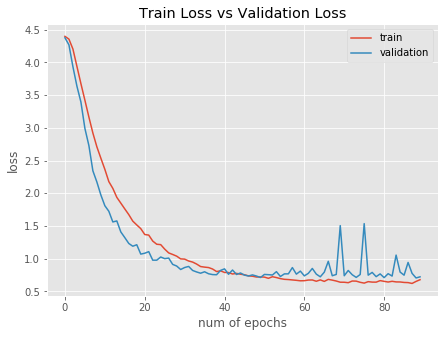

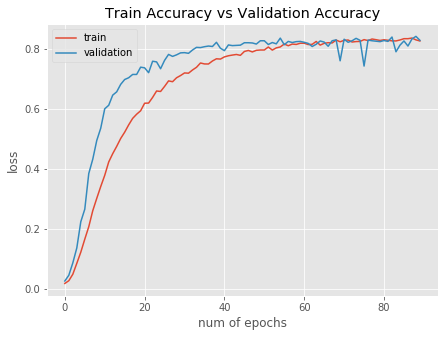

In [35]:
visualize_loss(xc,train_loss, validation_loss)
visualize_acc(xc, train_acc, validation_acc)

#### Visualizing the layers

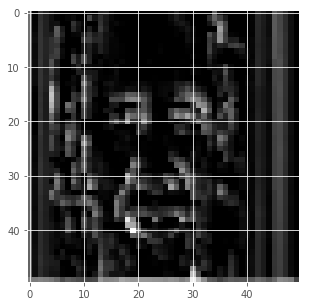

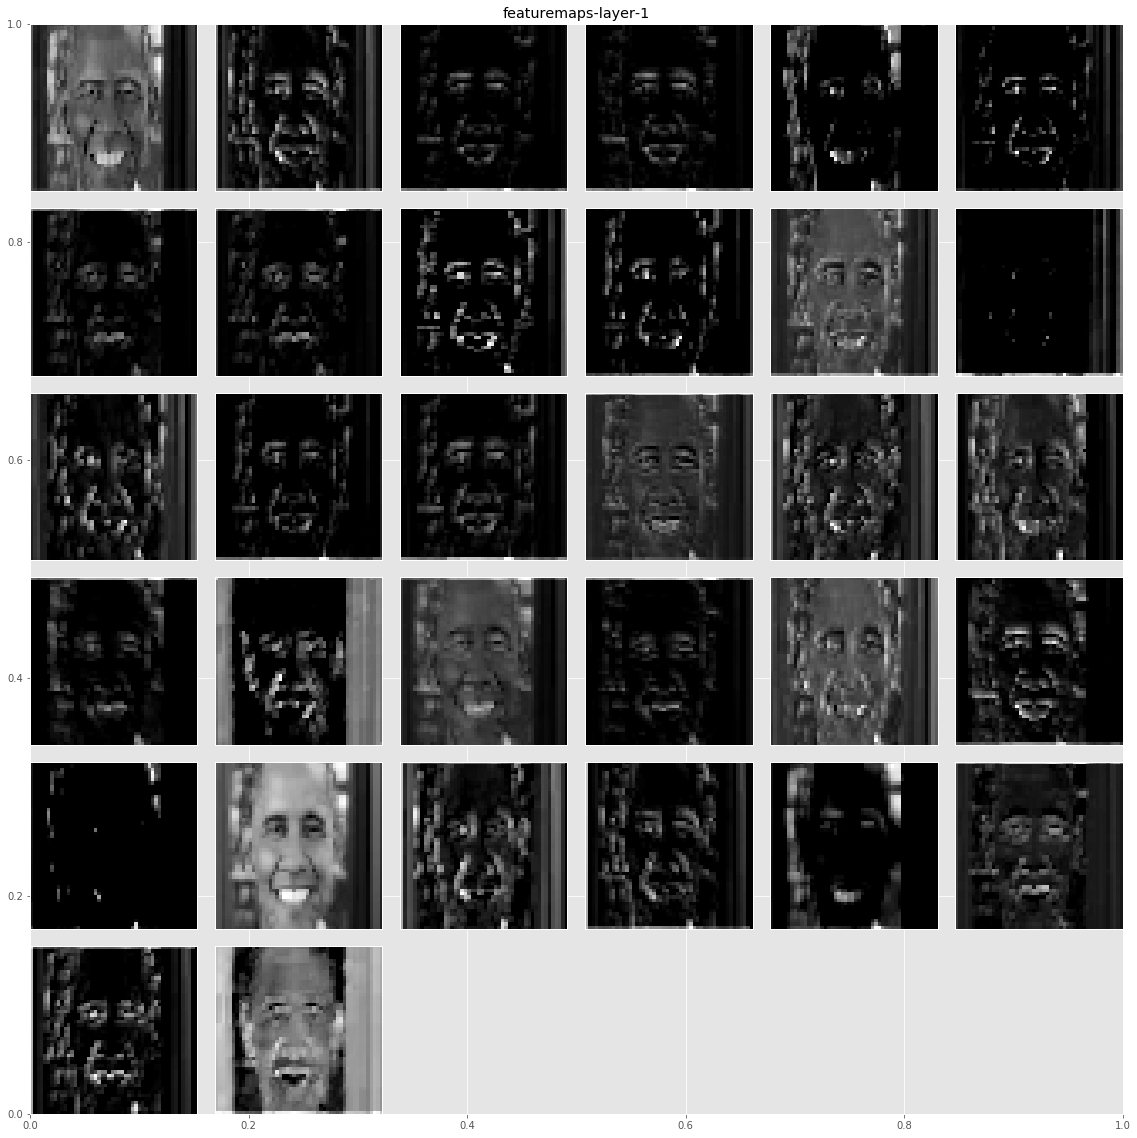

In [34]:
visualize_layer(model, test_image_tensor, layer_num=1)